

# **CSCI 567 Project, Phase 2**

Team Name: **ML_Gamblers**

Members: Amin Jabini, Nathan Justin, and Matin Barekatain

__________________________________________________________
In this notebook we go through comprehensive analysis and solutions of the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) project on Kaggle.
__________________________________________________________

In order to have an organized data analysis method, we consider the following aspects of the dataset to gain a better understanding of the data and find clues from it. These steps were inspired by [(Weng, 2019)](https://towardsdatascience.com/exploratory-data-analysis-eda-a-practical-guide-and-template-for-structured-data-abfbf3ee3bd9) .



1.   Preview of Data (High-Level Overview)
2.   Analyzing the Target Variables & Features
3.   Data Preprocessing
4.   Machine Learning Models
5.  Discussion & Conclusion
6. References

__________________________________________________________







We need the following dependecies:

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew,norm, probplot, kurtosis
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from copy import deepcopy
warnings.filterwarnings(action="ignore")
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.kernel_ridge import KernelRidge


from sklearn.svm import SVR
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm
from sklearn.metrics import r2_score


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We will use the ["(scipy.stats.skew)"](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) functions to compute the skewness of the sample data where [(skewness)](https://en.wikipedia.org/wiki/Skewness) is a measure of the asymmetry of the probability distribution of a random variable about its mean. The seaborn and matplot libraries are used for data visualization.

First, we read the data, extract its dimensions, and take a look at its high-level preview  (item 1) using the "head()" function:

In [ ]:
path_pref = '/content/gdrive/My Drive/CS 567 project/Final'

We will use the ["(scipy.stats.skew)"](https://colab.research.google.com/drive/1rthqqaATvWltfdme5wC3UL03dzqdwOi5?authuser=1#scrollTo=YVsDaRUSwERK&line=5&uniqifier=1) functions to compute the skewness of the sample data where [(skewness)](https://en.wikipedia.org/wiki/Skewness) is a measure of the asymmetry of the probability distribution of a random variable about its mean. The seaborn and matplot libraries are used for data visualization.

First, we read the data, extract its dimensions, and take a look at its high-level preview  (item 1) using the "head()" function:

In [ ]:
train = pd.read_csv(path_pref+'train.csv')
test = pd.read_csv(path_pref+'test.csv')

# See "Data Preprocessing" section on how to generate train_nonull and test_nonull
train_nonull = pd.read_csv(path_pref+'train_nonull.csv')
test_nonull = pd.read_csv(path_pref+'test_nonull.csv')


In [ ]:
print("Shape of Training data: ", train.shape)
print("Shape of Test data: ", test.shape)


Shape of Training data:  (1460, 81)
Shape of Test data:  (1459, 80)


# **Analyzing Target Variable**

Here we extract the metadata of the target variable, i.e., "SalesPrice" using the  "describe()" function.

In [ ]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The describe function does not provide a detailed overview of the statistical distribution of the dataset. To improve our knowledge of the target variable, first we plot its histogram and measure the skewness. Then as a common approach to improve the skewness, we take a look at its logarithm as well.

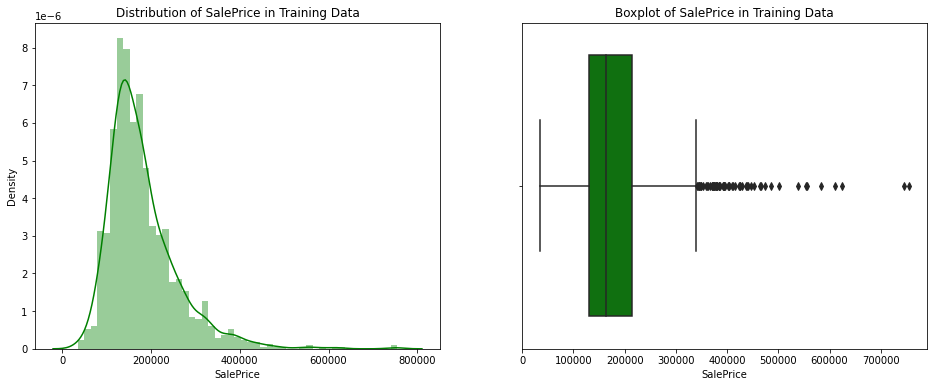

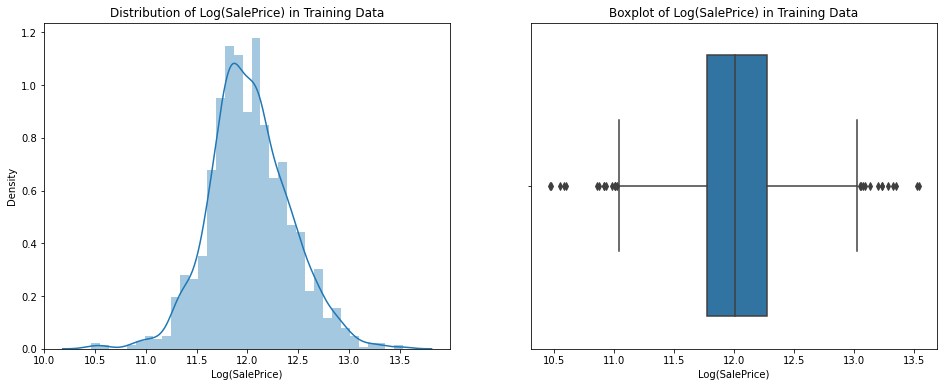


 | Target Variable   |   Skewness |   Coeff of Kurtosis |
|-------------------+------------+---------------------|
| SalePrice         |       1.88 |                6.51 |
| log(SalePrice)    |       0.12 |                0.8  |


In [ ]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(train['SalePrice'],ax=ax[0], color='green')
ax[0].set_title('Distribution of SalePrice in Training Data')

sns.boxplot(train['SalePrice'], color='green')
ax[1].set_title("Boxplot of SalePrice in Training Data")
plt.show()

f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(np.log(train['SalePrice']+1),ax=ax[0])
ax[0].set_title('Distribution of Log(SalePrice) in Training Data')

sns.boxplot(np.log(train['SalePrice']+1), ax=ax[1]) 
plt.setp(ax[:], xlabel='Log(SalePrice)')
ax[1].set_title("Boxplot of Log(SalePrice) in Training Data")
plt.show()
print('\n',tabulate([['SalePrice', "%3.2f" % train['SalePrice'].skew(), "%3.2f" % kurtosis(train['SalePrice']) ], ['log(SalePrice)', "%3.2f" % np.log1p(train['SalePrice']).skew(), "%3.2f" % kurtosis( np.log1p(train['SalePrice'])) ]], headers=['Target Variable', 'Skewness', 'Coeff of Kurtosis'], tablefmt='orgtbl'))


The histrogram and box plots for SalePrice data shows SalePrice a positive [(skew)](https://en.wikipedia.org/wiki/Skewness) and there is a significant difference between the 75 percentile and max. Taking the logarirthm reduces the skewness from 1.88 to 0.12, therefore, it makes the distribution more symmetric. The distribution of SalePrice has [(Kurtosis)](https://en.wikipedia.org/wiki/Kurtosis) of 6.51. This means that is is far from the Normal distribution (The Normal distribution has a coefficient of Kurtosis of 0). The logarithm transformation significantly normalizes the distribution of the target variable. Therefore, for the purpose of this project, it is more suitable to use log(SalePrice) as the target variable.

# **Analyzing features**

## Numerical Features

In [ ]:
train_logtarget = deepcopy(train_nonull)
train_logtarget['Log(SalePrice)'] = np.log1p(train_logtarget['SalePrice'])
train_logtarget.drop(columns=['SalePrice'], inplace=True)
train_logtarget = train_logtarget.set_index("Id")
train_logtarget = train_logtarget.drop(columns = ["Unnamed: 0"])

train_logtarget.to_csv(path_pref+'train_logtarget.csv')

numeric_data = train_logtarget.select_dtypes(include=[np.number])
print("There are {} numeric features".format(numeric_data.shape[1]))

There are 37 numeric features


In [ ]:
corr = numeric_data.corr()

Let's take a look at the corelations of features to the target variable. For this purpose, let's first look at the largest 10 positive and largest 10 negative correlations with the SalePrice.

In [ ]:
print (corr['Log(SalePrice)'].sort_values(ascending=False)[1:10], '\n')
print (corr['Log(SalePrice)'].sort_values(ascending=False)[-10:])

OverallQual     0.819240
GrLivArea       0.718844
GarageCars      0.680408
GarageArea      0.655212
TotalBsmtSF     0.641553
1stFlrSF        0.613742
FullBath        0.590919
YearBuilt       0.588977
YearRemodAdd    0.568986
Name: Log(SalePrice), dtype: float64 

PoolArea         0.040679
BsmtFinSF2       0.006420
BsmtHalfBath    -0.014974
MiscVal         -0.019752
YrSold          -0.034319
OverallCond     -0.036843
LowQualFinSF    -0.037698
MSSubClass      -0.075083
KitchenAbvGr    -0.147891
EnclosedPorch   -0.148636
Name: Log(SalePrice), dtype: float64


Among the features with positive correlation with SalePrice, the overall qual and gross living area have the most linear relation with the price. It is interesting to see OverallCond among the features that have negative correlation with SalePrice! This doesn't mean that having better overall quality hurts the price but it means that in this data, the houses with better overal condition may have other features like smaller living area that result in smaller sale price. Other feature with negative correlation like YrSold and EnclosedPorch follow the same rule. But the negative correlation of LowQualFinSF, the square footage of low-quality finish in all floors, makes total sense. Now let's take a look at all correlations in a bar chart. 

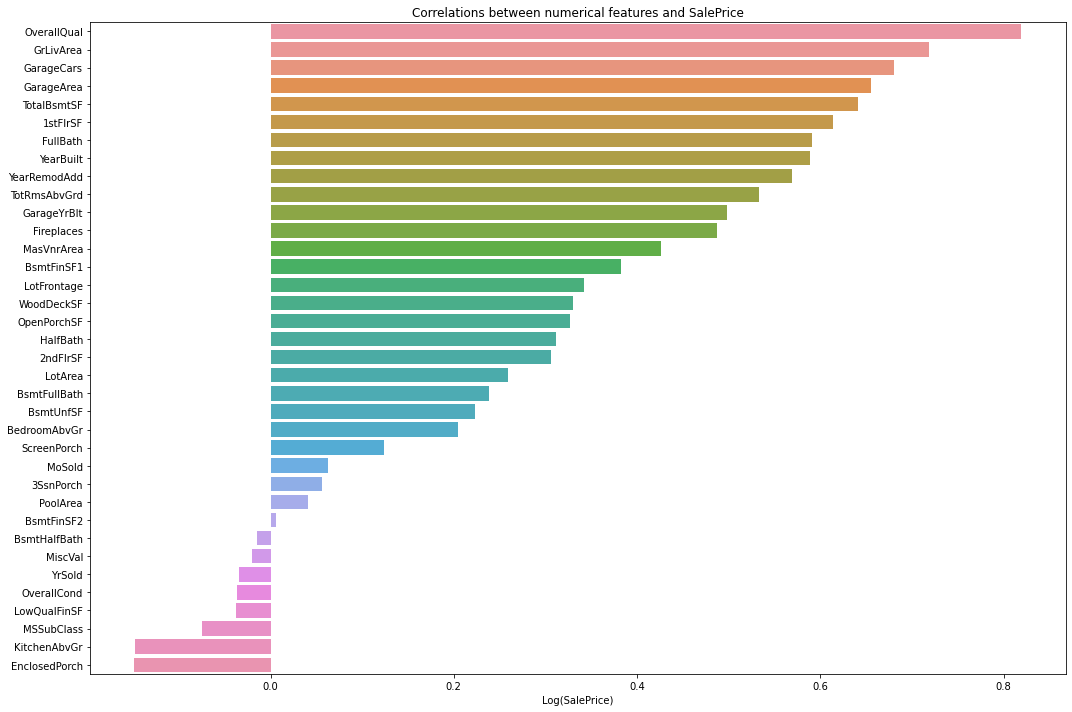

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x=corr['Log(SalePrice)'].sort_values(ascending=False)[1:], y=corr['Log(SalePrice)'].sort_values(ascending=False)[1:].index , orient="h")
plt.title("Correlations between numerical features and SalePrice")
plt.tight_layout()

Now, let's take a look at feature to feature correlations as well. For this purpose, we will plot the heatmap for the correlation matrix for the 12-most correlated features with the SalePrice. Here we used [dlookr package](https://cran.r-project.org/web/packages/dlookr/index.html) in R language that has an advanced visualization function plot correlate. The following cell shows the code we implemented in R to create this graph:

In [ ]:
print("Heatmap of Correlation Matrix for Select Features:")
# library(dlookr)
# library(dplyr)
# train<-read.csv("train_logtarget.csv")
# train_most_corr<-select(train, one_of(c("Log.SalePrice.", "X1stFlrSF", "OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd","GarageYrBlt") ))
# plot_correlate(train_most_corr)

Heatmap of Correlation Matrix for Select Features:


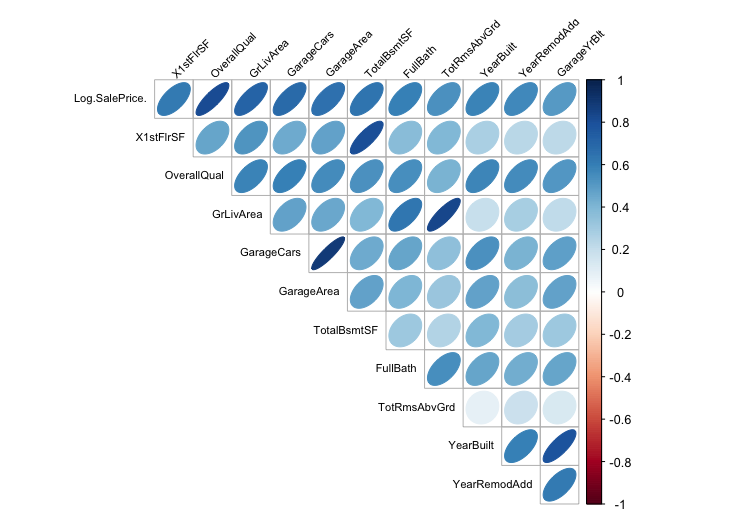

In this plot, the correlation of 0 between two variables is illustrated with a circle and the correlation of 1 (or -1) is a perfect line. Between these features, the basement square footage and the 1st floor square footage are correlated (which make sense). Also, it was expected that garage capicity and the garage area have significant positive correlation. The same thing holds for total rooms above grade and the living area. Now let’s plot each feature vs the target variable (log(SalePrice)) to have some insight. For each feature, we also plot the QQ-plot [(Guthrie, 2020)](https://www.itl.nist.gov/div898/handbook/) to assess the normality. Note that in QQ-plots, the more the blue points (allocated to our data) fits on the 45˚ red line (allocated to a theoretical normal distribution), the less skewness we will have. 

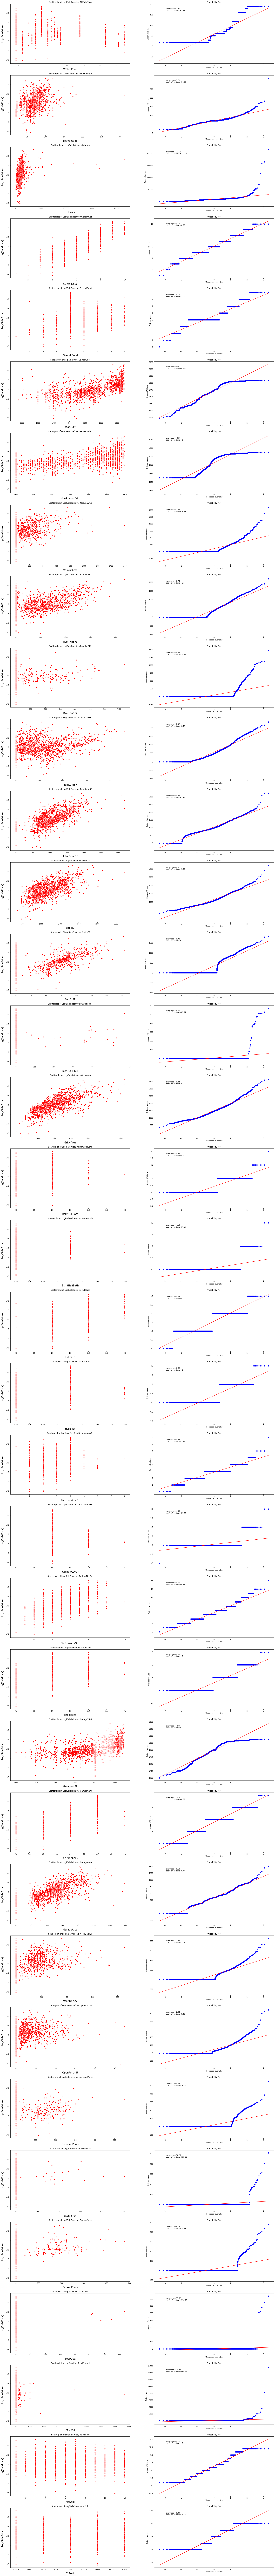

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
numeric_features = numeric_data.columns
for i in range(0,len(numeric_features)-1):
    feature = numeric_features[i]
    plt.subplot(len(numeric_features), 2, 2*i+1)
    sns.scatterplot(x=feature, y='Log(SalePrice)', data=train_logtarget, color='red')
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('Log(SalePrice)', size=15, labelpad=12.5)
    plt.title("Scatterplot of Log(SalePrice) vs " + feature)
    ax2= plt.subplot(len(numeric_features), 2, 2*i+2)
    res = probplot(x=train_logtarget[feature], plot=plt)
    # Skewness and Coeff of Kurtosis

    feat_skewness = train_logtarget[feature].skew()
    feat_kurtosis =  kurtosis(train_logtarget[feature])
    ax2.text(0.1, 0.9, s='skewness = {skew:3.2f} \ncoeff. of  kurtosis={kurtosis:3.2f}'.format(skew=feat_skewness, kurtosis=feat_kurtosis),transform=ax2.transAxes,  horizontalalignment='left', verticalalignment='center')
 
plt.show()
skewed = train_logtarget[numeric_features].apply(lambda x: skew(x))
skewed_index = skewed[skewed>0.75].index
train_logtarget[skewed_index] = np.log1p(train_logtarget[skewed_index])
test_nonull[skewed_index] = np.log1p(test_nonull[skewed_index])

Looking at the plots, there are a few data points that can are suspicious of being outliers, there are two in lot frontage and also one data point can be seen in the BsmtFinSF1 and 2. 
The probability plots and the skewness values show that almost none of the numerical features have Normal distribution. Therefore, transforming features can be helpful. 

Looking at the plots, there are a few data points that can are suspicious of being outliers, there are two in lot frontage and also one data point can be seen in the BsmtFinSF1 and 2. 
The probability plots and the skewness values show that almost none of the numerical features have Normal distribution. Therefore, transforming features can be helpful. 

## Categorical features

In [ ]:
categorical_features = train_nonull.dtypes[train_nonull.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_features))

Number of Categorical features:  41


To understand the range of values of the categorical features, their distribution, and their relationship to the sale price, we generate the following graphs
* A bar graph for each categorical feature showing the distribution of values among the training examples
* A box-and-whisker plot showing the distribution of sales prices for each value of each feature

To visualize categorical features, we will use preprocessed data (see Preprocessing section), where we fill in missing data with "None". This is because for categorical features, "NA" means that the category does not apply to the house.

In [ ]:
# Obtain the unique values in each categorical feature
categorical_values = {}
large_categories = []
for c in categorical_features:
    values = train_nonull[:][c].unique()
    categorical_values[c] = values
    
    # If a category is too large, put it in a separate pile
    if len(values) >= 10:
        large_categories += [c]

First, we create the bar graphs to see the distribution of values among qualitative features

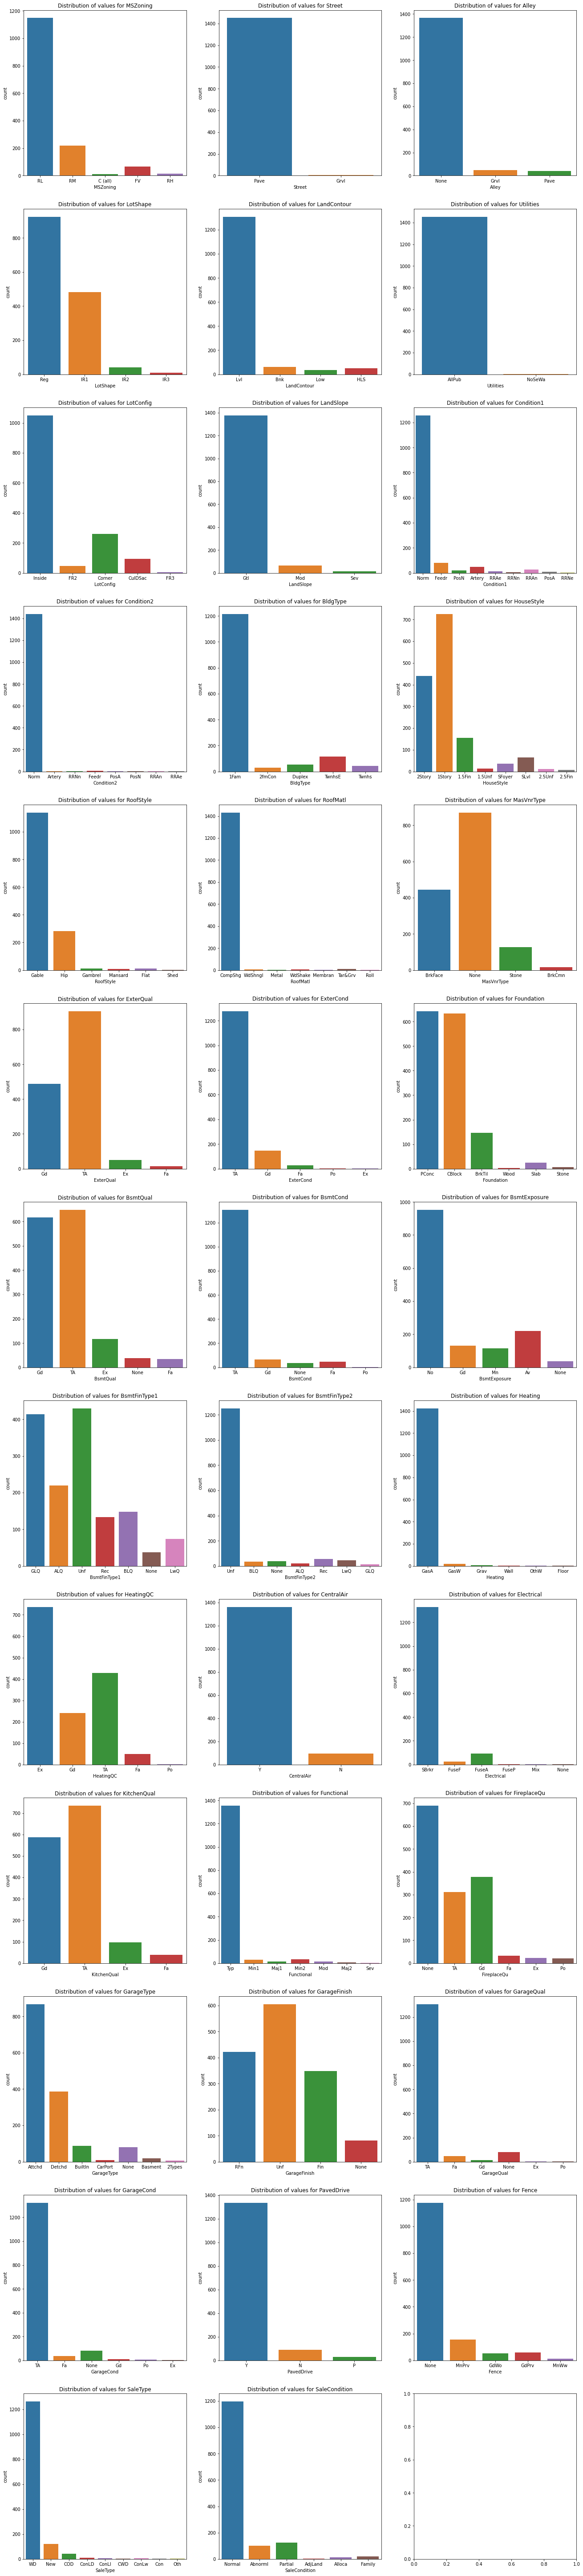

In [ ]:
# Visualize the frequency of values in each categorical feature
i = 0
fig, axs = plt.subplots(nrows = ((len(categorical_values) - len(large_categories)) // 3) + 1, ncols=3)
plt.subplots_adjust(right=3)
plt.subplots_adjust(top=20)
fig.tight_layout(pad=5)
for c in categorical_features:
    if c in large_categories:
        # We will deal with features that have a long range of values after this cell
        continue 
    sns.countplot(x=c, data=train_nonull, ax=axs[i // 3][i % 3])
    axs[i // 3][i % 3].set_title("Distribution of values for " + c)
    i += 1
plt.show()

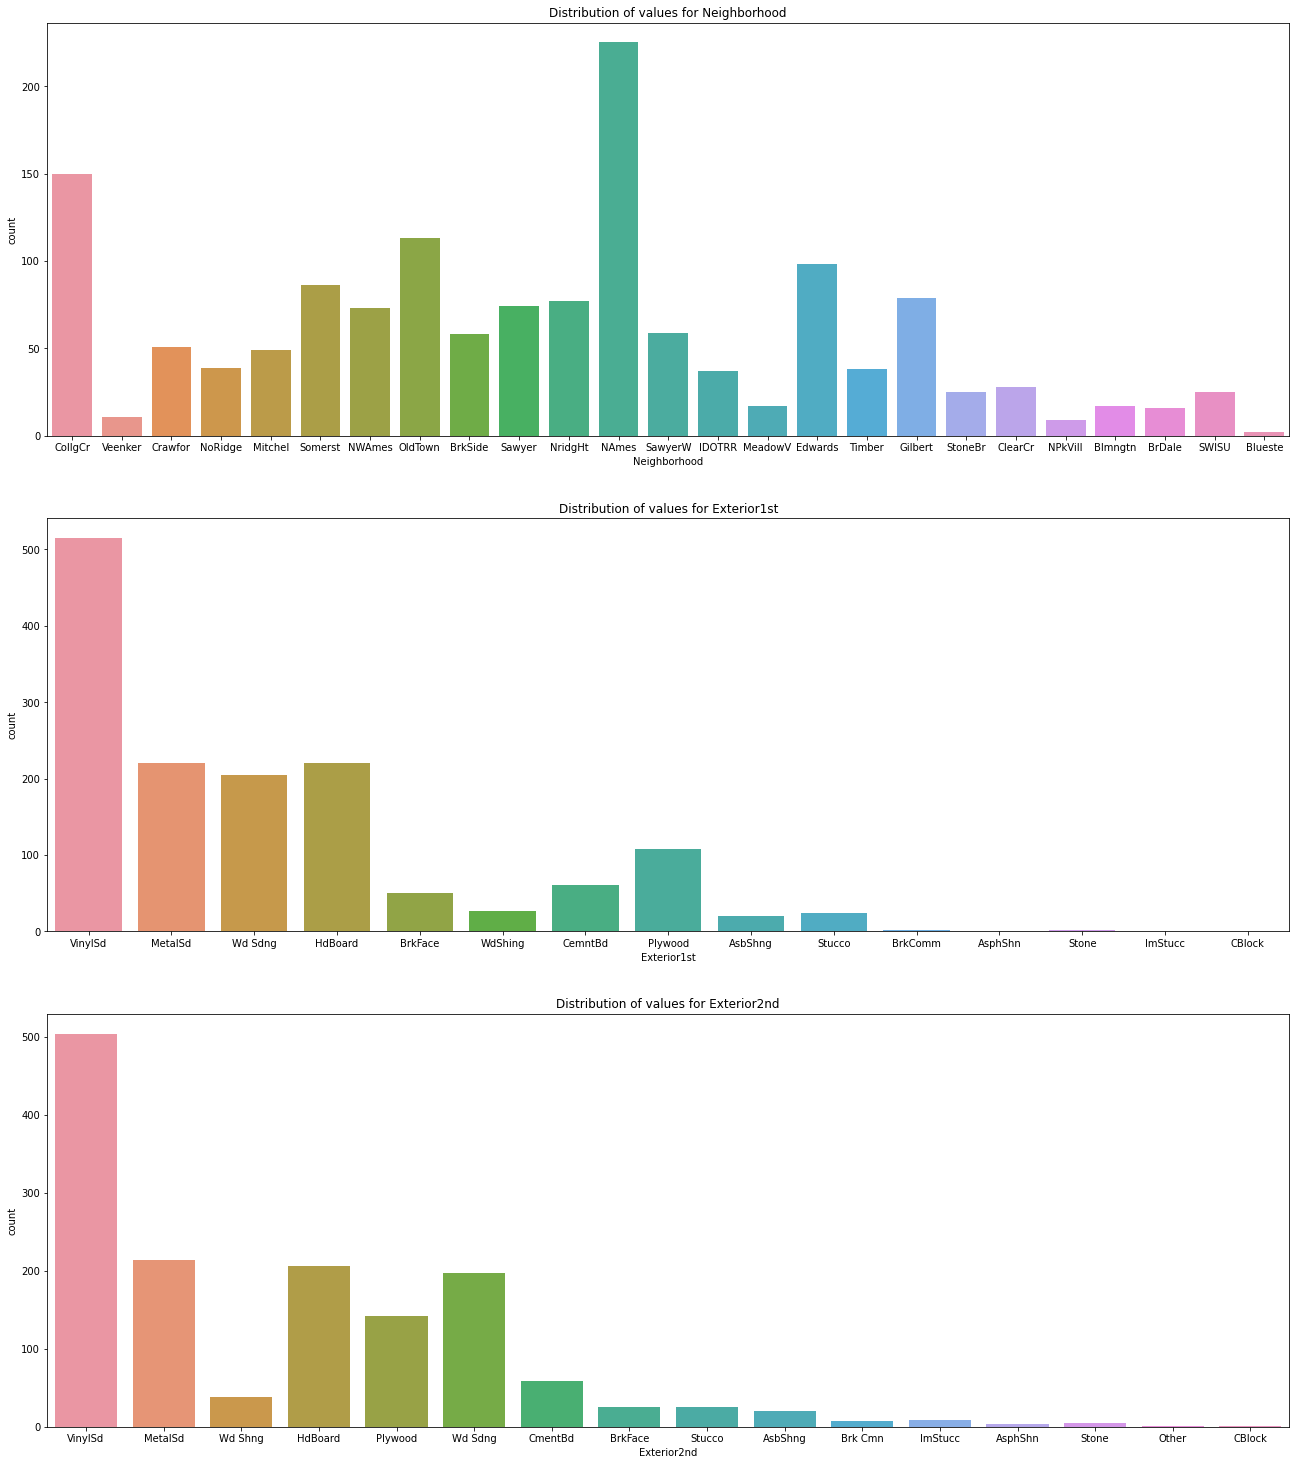

In [ ]:
# For larger distributions, give them more room
# In this dataset: features "Neighborhood", "Exterior1st", and "Exterior2nd"
i = 0
fig, axs = plt.subplots(nrows = (len(large_categories)), ncols=1)
plt.subplots_adjust(right=3)
plt.subplots_adjust(top=5)

for c in large_categories:
    sns.countplot(x=c, data=train_nonull, ax=axs[i])
    axs[i].set_title("Distribution of values for " + c)
    i += 1
plt.show()

Next, we generate box plots for each value to see the distribution of sales prices for each value of each categorical feature



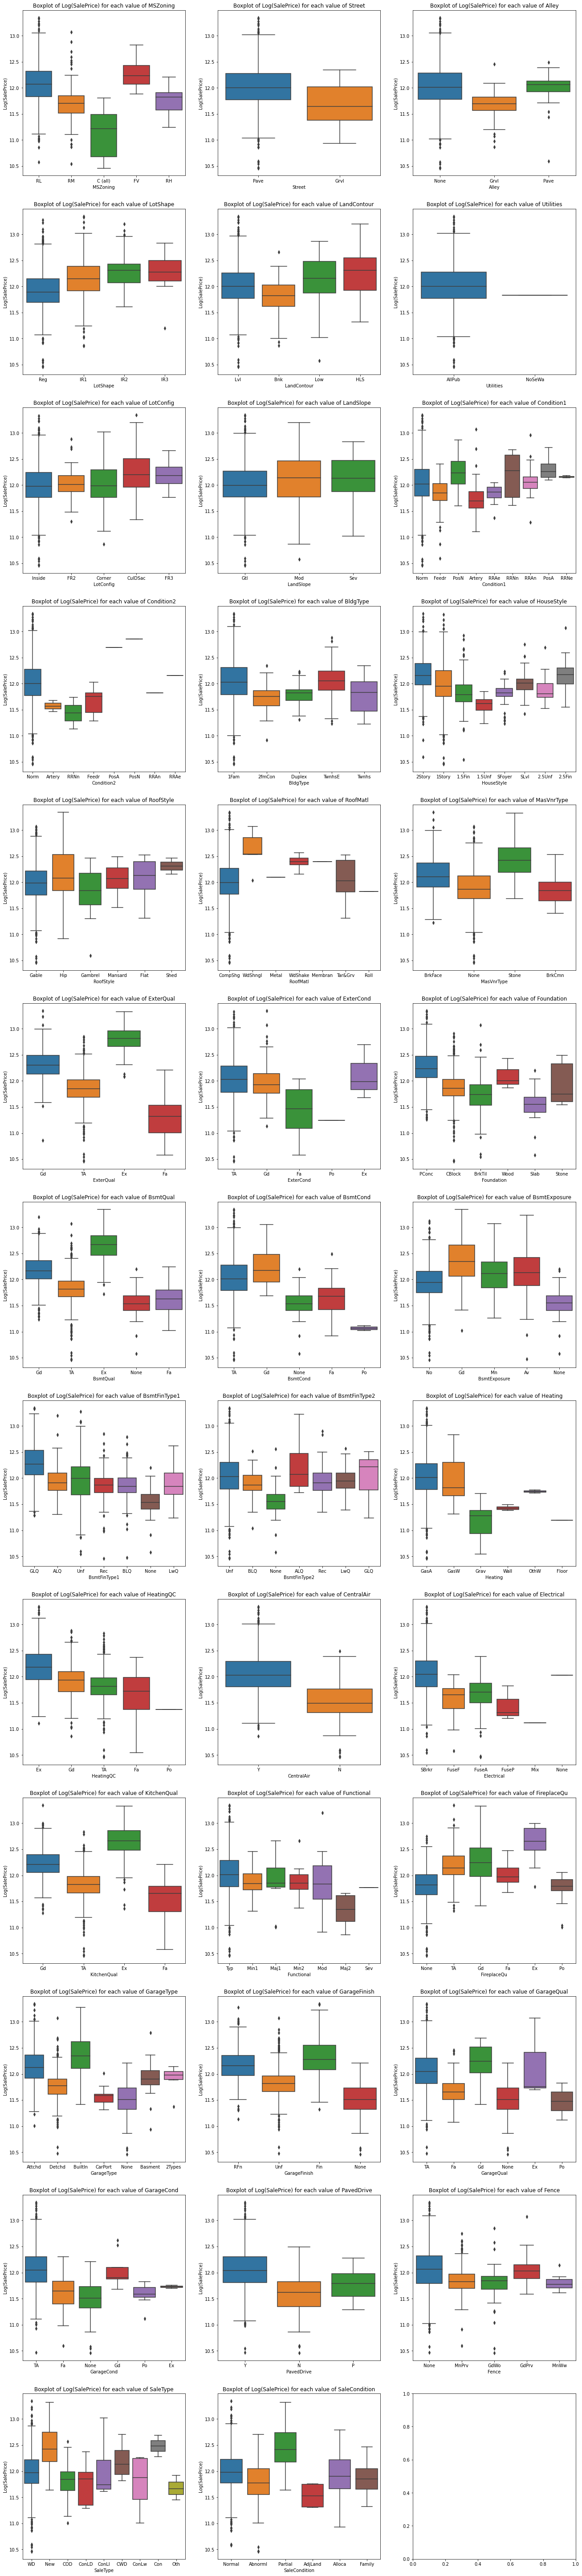

In [ ]:
# Create box plots for each categorical data
i = 0
fig, axs = plt.subplots(nrows = ((len(categorical_values) - len(large_categories)) // 3) + 1, ncols=3)
plt.subplots_adjust(right=3)
plt.subplots_adjust(top=20)
fig.tight_layout(pad=5)
for c in categorical_features:
    if c in large_categories:
        # We will deal with features that have a long range of values after this cell
        continue
    sns.boxplot(x=c, y='Log(SalePrice)', data=train_logtarget, ax=axs[i // 3][i % 3])
    axs[i // 3][i % 3].set_title("Boxplot of Log(SalePrice) for each value of " + c)
    i += 1
plt.show()

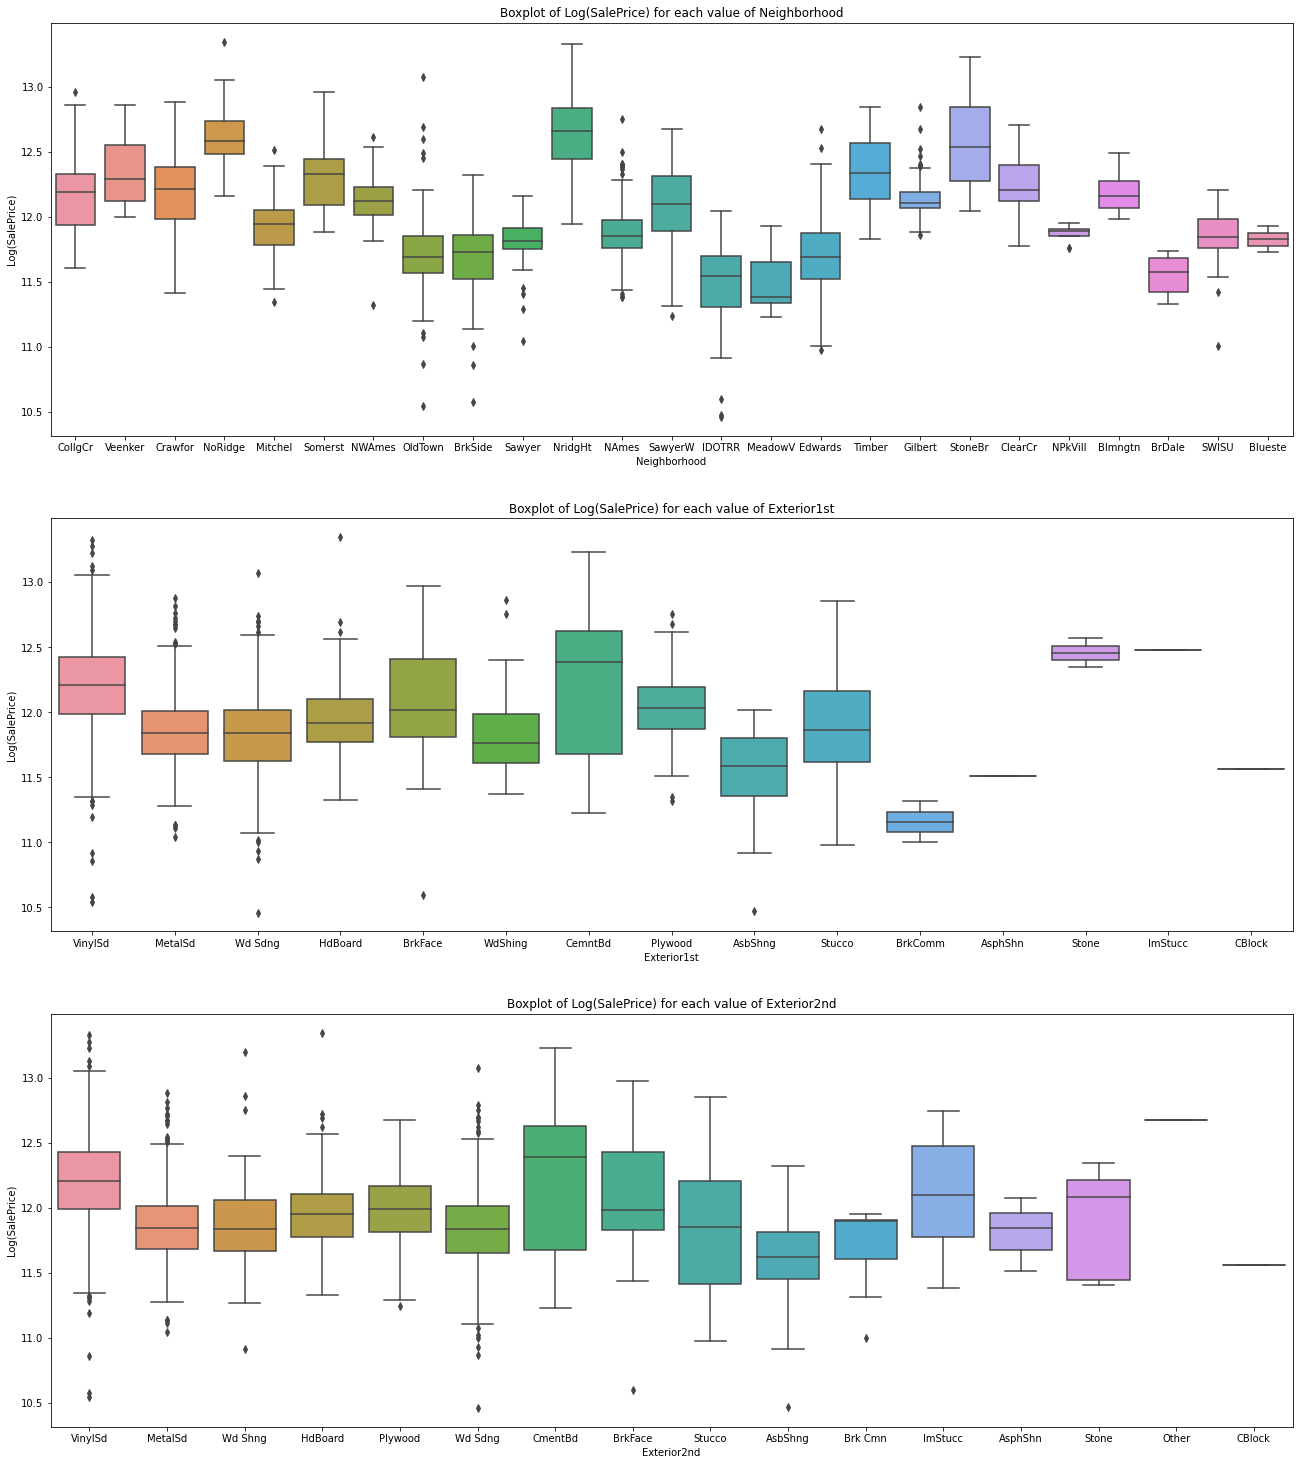

In [ ]:
# For larger distributions, give them more room
# In this dataset: features "Neighborhood", "Exterior1st", and "Exterior2nd"
i = 0
fig, axs = plt.subplots(nrows = (len(large_categories)), ncols=1)
plt.subplots_adjust(right=3)
plt.subplots_adjust(top=5)
for c in large_categories:
    sns.boxplot(x=c, y='Log(SalePrice)', data=train_logtarget, ax=axs[i])
    axs[i].set_title("Boxplot of Log(SalePrice) for each value of " + c)
    i += 1
plt.show()

Categorical Features Analysis:
* For most cateogorical features, there is one clear dominating value in the training data.
  - For these categorical features with one dminating value, they may not be as useful in training a model as almost all samples are of that value. For example, the training data at feature "Street" take on almost all the same value "Pave". So, we don't really gain any information about the influence of "Street" on the sales price, and if we change the sales price drastically on data with "Street" value "Grvl", we are prone to overfitting. These categorical values are candidates for removing from the dataset all together.
  - There are notable exceptions, however, where there is no single dominating value. These categorical features may be potentially more useful in training.
  - On the opposite end, features with a large range of values ("Neighborhood", "Exterior1st", "Exterior2nd") may prove more useful in determining house sales price.

* It's important to compare the bar graph and the box-and-whisker plot to see if differences in distribution are possibly due to small sample size / noise or doe to actual differences in price based on feature value.
  - One example showing how important this is the feature "Condition2". The box-and-whisker plot shows that data that have value "PosN" at "Condition2" have overall higher prices than data that don't have this value. However, looking at the bar graphs, we see that there are few samples with the value "PosN" to begin with, and thus this difference in sale price could be attributed to general lack of data with "PosN" as a value.
 
* The data is skewed right - even after dividing up the data by feature value
    - In almost all instances, we see from the box-and-whisker plots that at each category value, the skewedness of the data does not "disappear". In fact, in general we see that breaking down the data into one feature's values keeps the overall shape of the data, just with different means and standard deviations.

* There is noticable variation in sales price for some features where there isn't one dominating value - showing that the categorical data is a factor in sale price
    - The most notable of these is the feature "Neighborhood", where we see both a relatively significant variation in sales price among values and enough data in each feature to not warrant these differences on only noise in the data.
    - Some other features like this include "GarageQual", "GarageFinish", "GarageType", "FireplaceQual", "BsmtFinType1", and "BsmtQual"
    - We anticipate that factoring these features into our model would help our model be more accurate

# **Data Preprocessing (Phase 1)**

## Encoding of Categorical Data

Two common techniques used to deal with categorical data are to one-hot encode the data and to label encode the data. In one-hot encoding, for every feature with n possible values, we create n new features corresponding to each value of that feature. Then, the data takes on value 1 if the particular example has that value for that feature, and 0 otherwise. In label encoding, we directly map feature values to integer numbers.

The issue with one-hot encoding is that it greatly increases the number of features, which can add difficulty in learning a good model. The issue with label encoding is that it imposes a distance and ordering on non-numeric data, which may lead to unintended interpretations of the categorical feature by the model. We propose a hybrid approach to encoding categorical data: using one-hot encoding for features with unordered vaues and label encoding for features with some natural ordering to its values.

We decided which features to be one-hot encoded and which to be label encoded by our domain knowledge (in data_description.txt) and categorical feature analysis.

Sources of inspiration and insight:
* [(Choudhary, 2016)](https://www.kaggle.com/aharless/amit-choudhary-s-kernel-notebook-ified)
  - Helped us come up with the idea of combining one-hot encoding and label encoding
  - It also helped us understand how LASSO and XGBoost models would be potentially helpful for this project (We will discuss them in the next section of this report).
* [(Kartik, 2018)](https://www.kaggle.com/shahules/an-overview-of-encoding-techniques)
  - Helped us understand all of the different encoding techniques out there

The training data with the categorical features encoded is saved in the csv `train_encoded.csv`.

Our detailed notes on the categorical features can be found [here](https://docs.google.com/spreadsheets/d/1bmTfoUVTybXswzLPDYcEbSxlZCpDiZ5JOiQBUX9EF6E/edit?usp=sharing).

In [ ]:
# We have 4 classes of categorical features (see next cells for explanations)

# 1. One-Hot encoded features - features that have no ordering
one_hot_single = ['MSZoning', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood',
                'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType',
                'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 
                'SaleCondition']

# 2. One-Hot encoded features where two features in the data represent one feature
condition = ["Condition1", "Condition2"]
exterior = ["Exterior1st", "Exterior2nd"]
no_value = ["None", "Norm", "Oth"] # Values that won't get their own dummy variable

# 3. Label-Encoded Features - features that have some kind of ordering
rating_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                   'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
basement_finish = ['BsmtFinType1', 'BsmtFinType2']
label_encoded_unique = ['LotShape', 'Utilities', 'LandSlope', 'BsmtExposure',
                       'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

# Label encodings - determined by reading data_description.csv
# All encodings are for 0 to n-1 for n possible values
rating_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmtfintype_dict = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
lotshape_dict = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
utilities_dict = {'None': 3, 'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}
landslope_dict = {'Sev': 0, 'Mod': 1, 'Gtl': 2}
bsmtexposure_dict = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
functional_dict = {'None': 7, 'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
garagefinish_dict = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
paveddrive_dict = {'N': 0, 'P': 1, 'Y': 2}
fence_dict = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
unique_label_enc_dict = {'LotShape': lotshape_dict, 'Utilities': utilities_dict, 'LandSlope': landslope_dict,
                        'BsmtExposure': bsmtexposure_dict, 'Functional': functional_dict, 
                        'GarageFinish': garagefinish_dict, 'PavedDrive': paveddrive_dict, 'Fence': fence_dict}

# 4. Binary Features - Special case of label encoding
binary_features = ['Street', 'CentralAir']

# Label encodings
street_dict = {'Grvl': 0, 'Pave': 1}
centralair_dict = {'N': 0, 'Y': 1}
binary_dict = {'Street': street_dict, 'CentralAir': centralair_dict}

# Create new dataframe where encoded training data will be
train_encoded = deepcopy(train_logtarget)

**One-Hot Encoded Features**

We determine the values that a categorical feature can take on based on the training data. We use the following conventions:
  - An example in either the training set or test set will have all 0's for the one-hot-encoding of a feature if their value is "None"
  - An example in the test set will have all 0's for the one-hot-encoding of a feature if their value at that feature was not seen in the training data.

Special Cases
  - The features "Condition1" and "Condition2" are the same feature "Condition" but are broken into two in the dataset because an example is allowed to have 2 "Condition" values. These are merged in the one-hot encoded dataset. We do the same thing for "Exterior1st" and "Exterior2nd".
  - The features "BsmtFinType1" and "BsmtFinType2" also refer to the same feature based on basement finish type. However, we do not merge these two in the one-hot-encoding, as they are directly tied to the features "BsmtFinSF1" and "BsmtFinSF2" respectively.
  - We do not one-hot encode the following values since they either indicate that the feature is not applicable to example or that the example is in some miscellaneous category:
    - "None" (found in "Alley", "MasVnrType", and "GarageType")
    - "Norm" (found in "Condition1" and "Condition2")
    - "Oth" (found in "SaleType")

In [ ]:
# Create one-hot-encoded training data
train_encoded = train_encoded.drop(columns=one_hot_single)
train_encoded = train_encoded.drop(columns=condition)
train_encoded = train_encoded.drop(columns=exterior)

for c in one_hot_single:
    for v in categorical_values[c]:
        if v in no_value:
            continue # Will not one-hot encode "None", "Norm", nor "Oth"
            
        # Create new feature (format: "Feature=Value")
        new_col = np.zeros((len(train_encoded),), dtype=int)
        if c in condition:
            col_name = 'Condition=' + v
        elif c in exterior:
            col_name = 'Exterior=' + v
        else:
            col_name = c + '=' + v
        if not col_name in train_encoded.columns:
            train_encoded[col_name] = new_col
            
        # Fill in one-hot encoding
        for i in train_encoded.index:
            if train_logtarget.at[i,c] == v:
                train_encoded.at[i,col_name] = 1

# Print out the new features of the one-hot-encoded dataset
train_encoded.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'SaleType=ConLI', 'SaleType=CWD', 'SaleType=ConLw', 'SaleType=Con',
       'SaleCondition=Normal', 'SaleCondition=Abnorml',
       'SaleCondition=Partial', 'SaleCondition=AdjLand',
       'SaleCondition=Alloca', 'SaleCondition=Family'],
      dtype='object', length=165)

**Label-Encoded Features**

We determined the numerical encodings of feature labels through information from the given `data_description.txt` file.

We use the convention that a feature with `n` values can have integer values between 0 and `n-1`.

In [ ]:
# Label Encoded Features - Rated Features
train_encoded = train_encoded.drop(columns=rating_features)
for c in rating_features:
    new_col = np.zeros((len(train_logtarget),), dtype=int)
    train_encoded[c] = new_col    
    # Fill in one-hot encoding
    for i in train_encoded.index:
        num_value = rating_dict[train_logtarget.at[i,c]]
        train_encoded.at[i,c] = num_value

# Label Encoded Features - BsmtFinType Features
train_encoded = train_encoded.drop(columns=basement_finish)
for c in basement_finish:
    new_col = np.zeros((len(train_logtarget),), dtype=int)
    train_encoded[c] = new_col    
    # Fill in one-hot encoding
    for i in train_encoded.index:
        num_value = bsmtfintype_dict[train_logtarget.at[i,c]]
        train_encoded.at[i,c] = num_value

# Unique Encodings
train_encoded = train_encoded.drop(columns=label_encoded_unique)
for c in label_encoded_unique:
    new_col = np.zeros((len(train_logtarget),), dtype=int)
    train_encoded[c] = new_col    
    # Fill in one-hot encoding
    for i in train_encoded.index:
        value_dictionary = unique_label_enc_dict[c]
        num_value = value_dictionary[train_logtarget.at[i,c]]
        train_encoded.at[i,c] = num_value

# Binary Encodings
train_encoded = train_encoded.drop(columns=binary_features)
for c in binary_features:
    new_col = np.zeros((len(train_logtarget),), dtype=int)
    col_name = c
    if c == "Street":
        col_name += "=Pave"
    train_encoded[col_name] = new_col
    # Fill in one-hot encoding
    for i in train_encoded.index:
        value_dictionary = binary_dict[c]
        num_value = value_dictionary[train_logtarget.at[i,c]]
        train_encoded.at[i,col_name] = num_value

In [ ]:
# Save to a csv
train_encoded.to_csv(path_pref+'train_encoded.csv')

**Encoding of Test Data**

We encode the test data using the same encoding from our training data.

One special case we handle is that for features "Alley" and "Functional", they do not have "None" values in the training set, but "None" appears in the test set. In this scenario, we take the assign the given example the most common label from the training set, which is "AllPub" (with numeric value 3) for "Alley" and "Typ" (with numeric value 7) for "Functional"

In [ ]:
# Encode Test Data

# Create one-hot-encoded test data
test_encoded = deepcopy(test_nonull)
test_encoded = test_encoded.drop(columns=one_hot_single)
test_encoded = test_encoded.drop(columns=condition)
test_encoded = test_encoded.drop(columns=exterior)

for c in one_hot_single:
    for v in categorical_values[c]:
        if v in no_value:
            continue # Will not one-hot encode "None", "Norm", nor "Oth"
        
        if c in condition:
            col_name = 'Condition=' + v
        elif c in exterior:
            col_name = 'Exterior=' + v
        else:
            col_name = c + '=' + v
        if not col_name in test_encoded.columns:
            test_encoded[col_name] = np.zeros((len(test_encoded),), dtype=int)
            
        # Fill in one-hot encoding
        for i in range(len(test_encoded)):
            if test_nonull.at[i,c] == v:
                test_encoded.at[i,col_name] = 1

# Label Encoded Features - Rated Features
test_encoded = test_encoded.drop(columns=rating_features)
for c in rating_features:
    new_col = np.zeros((len(test_nonull),), dtype=int)
    test_encoded[c] = new_col    
    for i in range(len(test_encoded)):
        num_value = rating_dict[test_nonull.at[i,c]]
        test_encoded.at[i,c] = num_value

# Label Encoded Features - BsmtFinType Features
test_encoded = test_encoded.drop(columns=basement_finish)
for c in basement_finish:
    new_col = np.zeros((len(test_encoded),), dtype=int)
    test_encoded[c] = new_col    
    # Fill in one-hot encoding
    for i in range(len(test_encoded)):
        num_value = bsmtfintype_dict[test_nonull.at[i,c]]
        test_encoded.at[i,c] = num_value

# Unique Encodings
test_encoded = test_encoded.drop(columns=label_encoded_unique)
for c in label_encoded_unique:
    new_col = np.zeros((len(test_encoded),), dtype=int)
    test_encoded[c] = new_col    
    # Fill in one-hot encoding
    for i in range(len(test_encoded)):
        feat_value = test_nonull.at[i,c]
        value_dictionary = unique_label_enc_dict[c]
        num_value = value_dictionary[feat_value]
        test_encoded.at[i,c] = num_value

# Binary Encodings
test_encoded = test_encoded.drop(columns=binary_features)
for c in binary_features:
    new_col = np.zeros((len(test_nonull),), dtype=int)
    col_name = c
    if c == "Street":
        col_name += "=Pave"
    test_encoded[col_name] = new_col
    # Fill in one-hot encoding
    for i in range(len(test_encoded)):
        value_dictionary = binary_dict[c]
        num_value = value_dictionary[test_nonull.at[i,c]]
        test_encoded.at[i,col_name] = num_value

In [ ]:
# Save Encoded test set to csv
test_encoded = test_encoded.set_index("Id")
test_encoded = test_encoded.drop(columns = ["Unnamed: 0"])

test_encoded.to_csv(path_pref+'test_encoded.csv')

## Handling Outliers & Unwanted Features

Without choosing the model and tuning hyperparameters, it may not be feasible to detect outliers and remove them. However, we can roughly say that since there are only a couple of data points with **"GrLivArea" > 4000**, and "GrLivArea" is one of the most correlated linear feature to determine the house price, we can drop those samples. 

Also, the features **"PoolQC"** and **"MiscFeature"** have provided almost no information since most of their cells are none. So, we drop these features.

In [ ]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)
train.drop(columns=["PoolQC"], inplace=True)
train.drop(columns=["MiscFeature"], inplace=True)
test.drop(columns=["PoolQC"], inplace=True)
test.drop(columns=["MiscFeature"], inplace=True)

## Handeling NaNs 

Let's take a look on how many nans are there in each feature


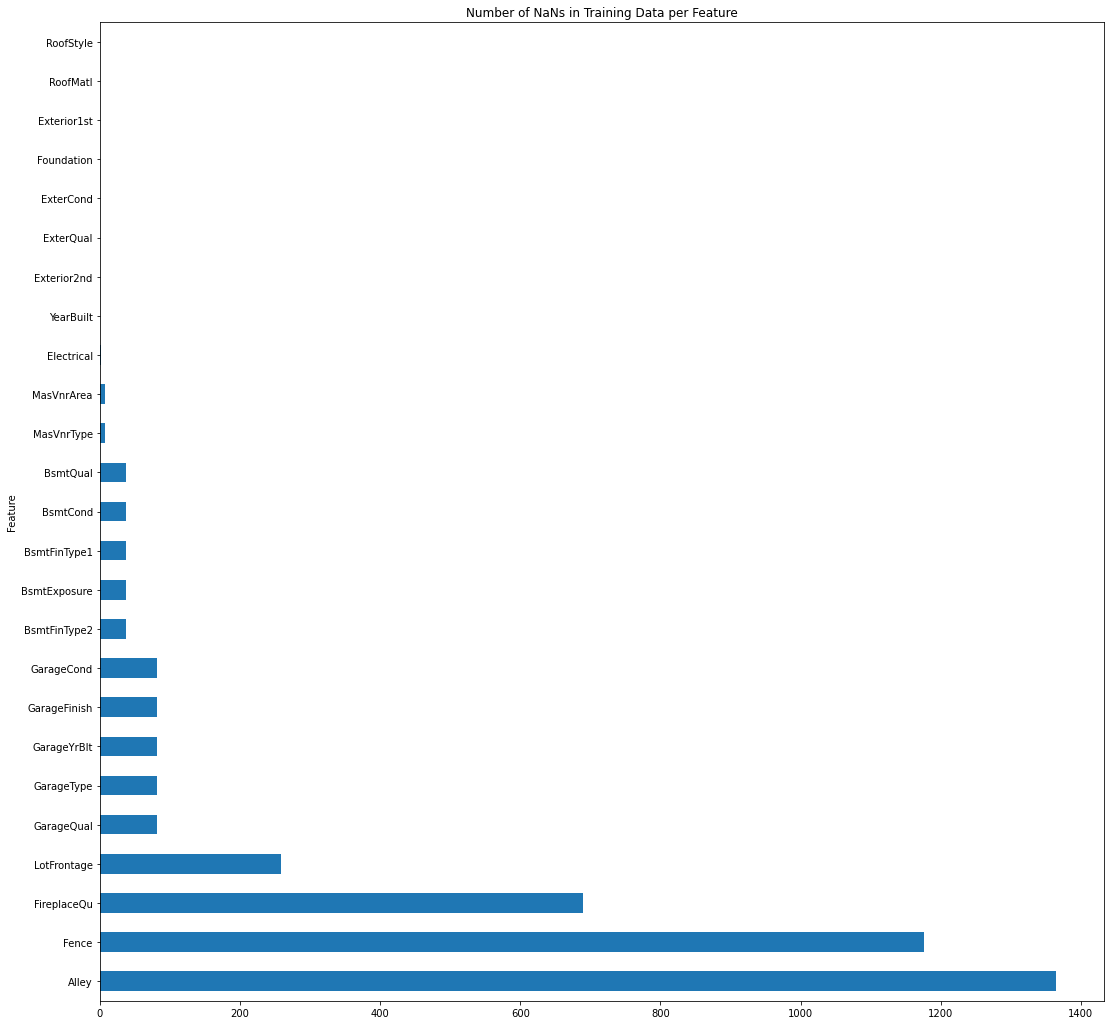

In [ ]:
fig, axs = plt.subplots(figsize=(18, 18))
Nans = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
Nans.columns = ['Number of Nans']
Nans.index.name = 'Feature'
Nans['Number of Nans'].plot.barh(title = "Number of NaNs in Training Data per Feature",
                                 xlabel = "Feature", ylabel = "Number of NaNs")


Based on the data description, in most of these columns that have Nan, Nan means zero or not-applicable. For example, in FireplaceQu (Fireplace quality), NA means it doesn't have any fireplace. For these feautres, we replace NaN with None:

In [ ]:
# There are columns that Nan means none
cols_fillna = ['Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']
for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    test[col].fillna('None',inplace=True) # Apply the same to the test set

For the remaining, Null means real missing data. Let's take a look at the percentage of the missing data:

In [ ]:
remaining_Nans = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([remaining_Nans, percentage], axis=1)
missing_data.columns = ['Missing Data', 'Percentage']
missing_data.head(5)

Missing Data  Percentage
LotFrontage           259    0.177885
GarageYrBlt            81    0.055632
MasVnrArea              8    0.005495
SalePrice               0    0.000000
ExterCond               0    0.000000

Let's fill the missing data with the median of the feature. Using the median makes the model more robust to the skewness of the feature data compared to the mean. The missing data in the test set is also filled with the median of the training data.

In [ ]:
train.fillna(train.median(), inplace=True)
test.fillna(train.median(), inplace=True)

Just to double-check, let's see if any Nan is still in the data_set:

In [ ]:
pd.DataFrame(train.isnull().sum().sort_values(ascending=False)).head(5)

0
SalePrice    0
ExterCond    0
RoofStyle    0
RoofMatl     0
Exterior1st  0

In [ ]:
pd.DataFrame(test.isnull().sum().sort_values(ascending=False)).head(5)

0
SaleCondition  0
ExterCond      0
RoofStyle      0
RoofMatl       0
Exterior1st    0

In [ ]:
train.to_csv(path_pref+'train_nonull.csv')
test.to_csv(path_pref+'test_nonull.csv')

## Normalizing Data

In order to prevent feature imbalances, we apply the Gaussian normalization method (i.e., subtracting each data by the mean of features and divide it by the standard deviation of those same features from the **training set**) to our training and test data. 


In [ ]:
# Standardize across features
train_encoded_mean = np.mean(train_encoded, axis=0)
train_encoded_std = np.std(train_encoded, axis=0)
train_encoded_std[train_encoded_std == 0] = 1 # Don't divide by 0
normalized_train_encoded = (train_encoded - train_encoded_mean)/(train_encoded_std)
normalized_test_encoded = (test_encoded - train_encoded_mean)/(train_encoded_std)

normalized_train_encoded.to_csv(path_pref+'normalized_train_encoded.csv')
normalized_test_encoded.to_csv(path_pref+'normalized_test_encoded.csv')


# Phase 2

Everything below this cell is what we explored in phase 2.

In [ ]:
def save_predictions(y_preds, name, path_pref, index_col ):
    """ Saves the preds array to name.csv
    Args:
      y_preds: (numpy array) predictions
      name: (str) file name
      path_pref: (str) path to current folder
      index_col: Index column of dataframe
    """
    predict_df = pd.DataFrame(y_preds)


    predict_df.rename(columns={0:'SalePrice',}, 
                     inplace=True)

    predict_df['Id']=index_col
    predict_df=predict_df.set_index('Id')

    predict_df.to_csv(path_pref+name+'.csv')

def test_outlier_replace(y_preds, min, max, avg):
  y_preds[(y_preds < min) | ((y_preds > max))] =avg
  return y_preds

# All Data For Phase 2

Data generated from Phase 1

In [ ]:
train = pd.read_csv(path_pref+'train.csv')
test = pd.read_csv(path_pref+'test.csv')

# See "Handeling NaNs" section on how to generate train_nonull and test_nonull
train_nonull = pd.read_csv(path_pref+'train_nonull.csv')
test_nonull = pd.read_csv(path_pref+'test_nonull.csv')

# train.csv but has Log(SalesPrice)
train_logtarget = pd.read_csv(path_pref+'train_logtarget.csv',index_col = 'Id')

# Has categorical features encoded
train_encoded = pd.read_csv(path_pref+'train_encoded.csv',index_col = 'Id')
test_encoded = pd.read_csv(path_pref+'test_encoded.csv',index_col = 'Id')

# Normalized data
normalized_train_encoded = pd.read_csv(path_pref+'normalized_train_encoded.csv', index_col = 'Id')
normalized_test_encoded = pd.read_csv(path_pref+'normalized_test_encoded.csv', index_col = 'Id')

# Data Preprocessing (Phase 2)

## Preprocessing of Normalized Data

*   We split our training data into features and labels to feed into our model
*   We order the features in both the training and testing data



In [ ]:
y_whole = train_encoded['Log(SalePrice)'].copy(deep=True)
X_whole = normalized_train_encoded.drop(columns=['Log(SalePrice)'])

X_test = normalized_test_encoded.drop(columns=['Log(SalePrice)'])

X_whole_df = pd.DataFrame(X_whole)
X_whole_df = X_whole_df.sort_index(axis=1)

X_test_df = pd.DataFrame(X_test)
X_test_df = X_test_df.sort_index(axis=1)


## Outlier Detection

Outliers in our training data are examples whose features are not similar to other examples in the data set. These can become an issue during training because if an example is unlike others, then our model will be skewed by the outliers and produce less probable predictions as a result. Thus, to improve our models, we want to detect and remove outliers.

One outlier detection method are Isolation Forests [(Liu et. al., 2008)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4781136). In short, isolation forests recursively partition the sample space with decision stumps until outlier points are isolated from the rest of the data set in their own leaves. 

This unsupervised learning method works well for high-dimensional data and requires no assumptions on the data, which is why we have decided to use this method for outlier detection.


In [ ]:
# Using sklearn's default hyperparameter values
iso_forest = IsolationForest(random_state=123) 
iso_forest = iso_forest.fit(X_whole_df)

outlier_indicator = iso_forest.predict(X_whole_df)
print("Number of outliers found: ", len(X_whole_df[outlier_indicator == -1]))

# Get the subset of data that does not include outliers
X_whole_no_outliers = X_whole_df[outlier_indicator == 1]
y_whole_no_outliers = y_whole[outlier_indicator == 1]


X_whole_no_outliers.to_csv(path_pref+'X_whole_no_outliers.csv')
y_whole_no_outliers.to_csv(path_pref+'y_whole_no_outliers.csv')
X_test_df.to_csv(path_pref+'X_test_df.csv')


Number of outliers found:  11


With this random seed, we have detected 11 outliers. We can change the seed to get a different number of outliers, but we decided that 11 outliers was a reasonable number of outliers to remove from our training data since that accounted for slightly less than 1% of our total data.

We can visualize these 11 outliers by using PCA to plot these points in 2D (inspired by [Khrishnan 2019](https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2/)), and seeing if these 11 outliers lie approximately away from the rest of the other points.

Total Explained variance from 2 components:  0.12975730754136294


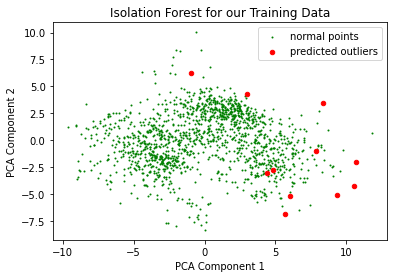

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X_whole_df)
print("Total Explained variance from 2 components: ", sum(pca.explained_variance_ratio_))

X_no_outliers_pca = pca.transform(X_whole_no_outliers)
X_outliers_pca = pca.transform(X_whole_df[outlier_indicator == -1])
plt.title("Isolation Forest for our Training Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

b1 = plt.scatter(X_no_outliers_pca[:,0], X_no_outliers_pca[:,1], c='green', s=1, label="normal points")
b1 =plt.scatter(X_outliers_pca[:,0],X_outliers_pca[:,1], c='red',s=20,label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

We see that most of the outliers do lie in the fringes of the data, as we expect. Note that plotting the data in 2D only accounts for 13% of the variance, so any points that look closer to the centers of different clusters of points can still be outliers (however, we cannot visualize these points easily).

## Dimensionality Reduction

We can use dimensionality reduction to simplify our data by capturing the variance in the data within a lower dimension. This helps prevent overfitting, as dimensionality reduction in effect removes low-variance dimensions in our data.

The dimensionality reduction technique we use is PCA.

First, we explore what our data looks like if transformed into PCA space

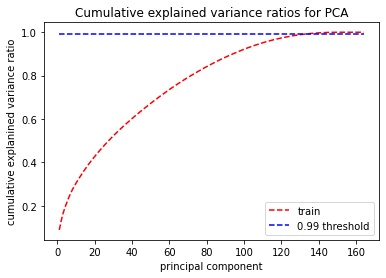

Number of components needed to reach threshold:
132


In [ ]:
# Choose threshold for graph
threshold = 0.99

n_features = len(X_whole_no_outliers.columns)
pca = PCA(n_components = n_features)
pca.fit(X_whole_no_outliers)

plt.xlabel('principal component')
plt.ylabel('cumulative explanined variance ratio')
plt.title("Cumulative explained variance ratios for PCA")
plt.plot(list(range(1,n_features + 1)), np.cumsum(pca.explained_variance_ratio_), 'r--', label="train")
plt.plot(list(range(1,n_features + 1)), [threshold] * (n_features), 'b--', label= str(threshold) + " threshold")
plt.legend()
plt.show()

print("Number of components needed to reach threshold:")
print(sum(np.cumsum(pca.explained_variance_ratio_) < threshold) + 1)

The above graph tells us that we can capture at least 99% of the variance in the data within 132 dimensions. That is, we can reduce the dimension of our data from 164 to 132 wihtout losing much information.

Reducing the dimension of our data can help with overfitting since it removes the effect of unnecessary features. However, it is hard to tell whether our models themselves will improve with a reduction in dimension.

So, we want to see how the number of components impacts training and validation error for a certain model:

In [ ]:
def PCA_ncomponents_trial(X_whole_no_outliers, y_whole_no_outliers):
    
    components = list(range(1,165,5))
    n_folds = 10

    avg_train_error = []
    avg_test_error = []

    kf = KFold(n_splits = n_folds, random_state=0, shuffle=True)
    kf.get_n_splits(X_whole_no_outliers)
    for c in components:
        train_error = []
        test_error = []
        for train_index, test_index in kf.split(X_whole_no_outliers):
            X_train, X_dev = X_whole_no_outliers.iloc[train_index], X_whole_no_outliers.iloc[test_index]
            y_train, y_dev = y_whole_no_outliers.iloc[train_index], y_whole_no_outliers.iloc[test_index]
            pca = PCA(n_components = c)
            pca.fit(X_train)
            X_train_pca = pca.transform(X_train)
            X_dev_pca = pca.transform(X_dev)
            model = Lasso(alpha=0.00004, max_iter=100000)
            model.fit(X_train_pca, y_train)
            y_train_predict = model.predict(X_train_pca)
            train_error += [mean_squared_error(y_train, y_train_predict, squared=False)]
            y_dev_predict = model.predict(X_dev_pca)
            test_error += [mean_squared_error(y_dev, y_dev_predict, squared=False)]

        avg_train_error += [sum(train_error) / n_folds]
        avg_test_error += [sum(test_error) / n_folds]
        
    plt.xlabel('number of components')
    plt.ylabel('average error')
    plt.title("PCA")
    plt.plot(components, avg_train_error, 'r--', label="train")
    plt.plot(components, avg_test_error, 'b--', label="development")
    plt.legend()
    plt.show()

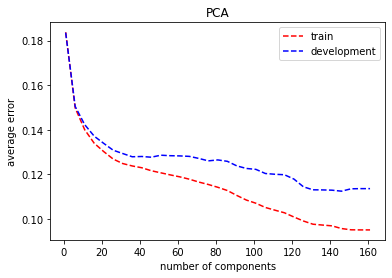

In [ ]:
PCA_ncomponents_trial(X_whole_no_outliers, y_whole_no_outliers)

For Lasso Regression, we see that the effect of reducing the dimension does not help with the testing data, as the minimum development error is around the range of a large number of components. So, any overfitting occurring with lasso regression must come from another factor (likely the fact that we have too few training data or we have not removed all outliers).

To see how PCA affects XGBoost, we cannot run cross validation due to the slow training time of XGBoost. So, we run metrics on one development set instead of doing cross validation, which will still help us get a decent estimate on how PCA can help XGBoost

In [ ]:
def PCA_ncomponents_trial_xgb(X_whole_no_outliers, y_whole_no_outliers):
    # Number of components
    components = list(range(1,160,10))
    seed = 0

    train_error = []
    test_error = []

    X_train, X_dev, y_train, y_dev = train_test_split(X_whole_no_outliers, y_whole_no_outliers, test_size=0.10, random_state=seed)

    for c in components:
        pca = PCA(n_components = c)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_dev_pca = pca.transform(X_dev)
        model = xgb.XGBRegressor(
                  colsample_bytree=0.2,
                  gamma=0.0,
                  learning_rate=0.05,
                  max_depth=6,
                  min_child_weight=1.5,
                  n_estimators=7200,                                                                  
                  reg_alpha=0.9,
                  reg_lambda=0.6,
                  subsample=0.2,
                  seed=42,
                  silent=1
          )
        model.fit(X_train_pca, y_train)
        y_train_predict = model.predict(X_train_pca)
        train_error += [mean_squared_error(y_train, y_train_predict, squared=False)]
        y_dev_predict = model.predict(X_dev_pca)
        test_error += [mean_squared_error(y_dev, y_dev_predict, squared=False)]
    plt.xlabel('number of components')
    plt.ylabel('error')
    plt.title("PCA on XGBoost")
    plt.plot(components, train_error, 'r--', label="train")
    plt.plot(components, test_error, 'b--', label="development")
    plt.legend()
    plt.show()

In [ ]:
# # Due to long runtime (3 minutes), the output graph is shown in the next cell.
# # Uncomment the following line to run the code.
# PCA_ncomponents_trial_xgb(X_whole_no_outliers, y_whole_no_outliers)

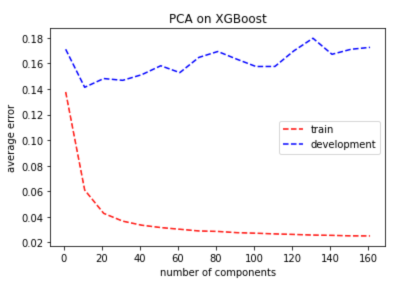

The above graph gives reason to believe that there might be some benefit to doing PCA on XGBoost. However, in our Kaggle submissions, the results of using PCA have not been as good as the results from not using PCA (with scores ranging from 0.15 to 0.17).

A potential reason as to why is because the shape of the testing set may differ from the training set enough to where PCA will not effectively reduce the dimension of the testing set. We can verify that this is the issue by looking at the means of the test data. 

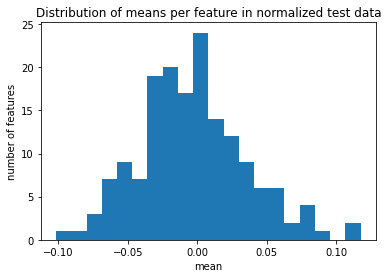

In [ ]:
test_features_mean = X_test_df.mean(axis=0)
plt.hist(test_features_mean, bins=20)
plt.xlabel('mean')
plt.ylabel('number of features')
plt.title("Distribution of means per feature in normalized test data")
plt.show()

In [ ]:
print("Mean of test data means", np.mean(test_features_mean))
print("Standard deviation of test data means", np.std(test_features_mean))

Mean of test data means -0.0026804083918961336
Standard deviation of test data means 0.03823501289036714


We see that the distribution of the testing data, after normalizing by the training data, is not exactly centered for each feature. Ideally, we would want this distribution to be very narrow and centered around 0 (like the training data). As we can see from our histogram, there are several features that are relatively far away from the mean of 0, and thus may cause the PCA transformation of the testing data to not be as accurate as we would like.

# **Machine Learning Models**

Exploring potential ML models, and recalling their pros and cons for this project is of great importance. 

A baseline solution for this regression problem is to perform a linear regression with one-hot categorical features. The accuracy of this simple model is expected to be much lower than top notch records in the Kaggle's leaderboard. 

Reviewing the EDA gives us the initial insight that what should be cleaned in the preprosessing step are mostly just some outliers and it is hard to observe a severe systematic noise in this problem. We will approach simpler algorithms including regularized linear regression models such as "LASSO" and "Ridge" Regression. We also explore decision trees combined with boosting techniques and we expect to overcome overfitting to get a high accuracy using these models.

## LASSO & Ridge Regression

In Ridge Regression we minimize:

$$L = ||Y-WX||_2^2+\alpha||W||_2^2$$

While in LASSO we simply consider the $1^{st}$ norm of $W$ for the regularization:

$$L = ||Y-WX||_2^2+\alpha||W||_1$$

For implementing these algorithms, we will use [scikit-learn](https://scikit-learn.org/stable/index.html), an open-source machine learning tool based on numpy, scipy, and matplotlib. The LASSO [(Kim et. al., 2007)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4407767) and Ridge [(Rifkin, 2007)](https://dspace.mit.edu/bitstream/handle/1721.1/37318/MIT-CSAIL-TR-2007-025.pdf?sequence=1) algorithms will be implemented as the following.

### Hyperparameter Tuning
The first step of building our Lasso and Ridge Regression models are finding what regularization parameter to use. We use cross validation to estimate the effect of the regularization multiplier $\alpha$ on estimation.


First, we tune the regularization parameter that we will use for Lasso Regression by checking the average error over all folds on different parameter values.

In [ ]:
# Change these variables to test different regularization parameters and number of folds
alphas_lasso = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001]
n_folds = 20

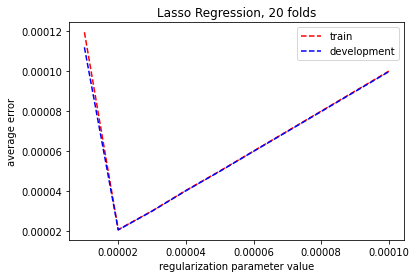

In [ ]:
clf_lasso = GridSearchCV(estimator=Lasso(max_iter=100000), param_grid={'alpha':alphas_lasso}, scoring = 'neg_root_mean_squared_error', return_train_score=True, cv=n_folds)
clf_lasso.fit(normalized_train_encoded, y_whole)
plt.xlabel('regularization parameter value')
plt.ylabel('average error')
plt.title("Lasso Regression, " + str(n_folds) + " folds")
plt.plot(clf_lasso.cv_results_["param_alpha"], -clf_lasso.cv_results_["mean_train_score"], 'r--', label="train")
plt.plot(clf_lasso.cv_results_["param_alpha"], -clf_lasso.cv_results_["mean_test_score"], 'b--', label="development")
plt.legend()
plt.show()

According to our cross-validation experiments, we should use $\alpha = 0.00002$ as our regularization parameter for Lasso Regression.

Next, we tune the regularization parameter for Ridge Regression in an identical process as Lasso Regression:

In [ ]:
# Change these variables to test different regularization parameters and number of folds
alphas_ridge = [0.0000005, 0.0000007, 0.000001, 0.000003, 0.000005, 0.000006, 0.000007, 0.000008, 0.000009, 0.00001]
n_folds = 20

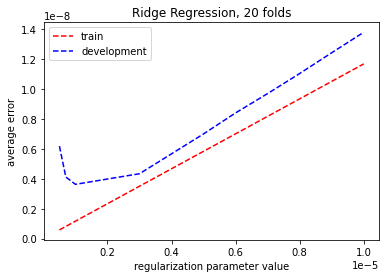

In [ ]:
clf_ridge = GridSearchCV(estimator=Ridge(max_iter=100000), param_grid={'alpha':alphas_ridge}, scoring = 'neg_root_mean_squared_error', return_train_score=True, cv=n_folds)
clf_ridge.fit(normalized_train_encoded, y_whole)
plt.xlabel('regularization parameter value')
plt.ylabel('average error')
plt.title("Ridge Regression, " + str(n_folds) + " folds")
plt.plot(clf_ridge.cv_results_["param_alpha"], -clf_ridge.cv_results_["mean_train_score"], 'r--', label="train")
plt.plot(clf_ridge.cv_results_["param_alpha"], -clf_ridge.cv_results_["mean_test_score"], 'b--', label="development")
plt.legend()
plt.show()

According to our cross-validation experiments, we should use $\alpha = 0.000003$ as our regularization parameter for Ridge Regression.

### Model Implementation
We implement our lasso and ridge regression models below. We divide our dataset into training and dev sets.

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_whole_no_outliers, y_whole_no_outliers, test_size=0.15, random_state=123)

In [ ]:
tuned_alpha_lasso = 0.00002 # this hyperparameter should be tuned with cross-validation
reg_lasso = Lasso(alpha=tuned_alpha_lasso, max_iter=100000) # Linear Model trained with L1 prior as regularizer

In [ ]:
tuned_alpha_ridge = 0.000003 # this hyperparameter should be tuned with cross-validation
reg_ridge = Ridge(alpha=tuned_alpha_ridge, max_iter=100000) # Linear least squares with l2 regularization

We then use the fit() function to fit the model with coordinate descent. The difference between the coordinate descent and gradient descent is that the former updates one parameter at a time, while the latter attempts to update all parameters at once.

In [ ]:
reg_lasso.fit(X_train, y_train)

Lasso(alpha=2e-05, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
reg_ridge.fit(X_train, y_train)

Ridge(alpha=3e-06, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, random_state=None, solver='auto', tol=0.001)

After fitting the model into the training data, we measure the mean squared error between the log of the predicted values and the target labels. We run the predict() function to predict labels as the following:

In [ ]:
y_train_predict_lasso = reg_lasso.predict(X_train)
print("Lasso score on training set: ", mean_squared_error(y_train, y_train_predict_lasso, squared=False))

Lasso score on training set:  0.09432856192815176


In [ ]:
y_train_predict_ridge = reg_ridge.predict(X_train)
print("ridge score on training data: ", mean_squared_error(y_train, y_train_predict_ridge, squared=False))

ridge score on training data:  0.0943248850081181


Then, we find the error on the development data.

In [ ]:
y_dev_predict_lasso = reg_lasso.predict(X_dev)
print("Lasso score on training set: ", mean_squared_error(y_dev, y_dev_predict_lasso, squared=False))

Lasso score on training set:  0.11635755497025346


In [ ]:
y_dev_predict_ridge = reg_ridge.predict(X_dev)
print("ridge score on training data: ", mean_squared_error(y_dev, y_dev_predict_ridge, squared=False))

ridge score on training data:  0.11656206262376026


We train our Ridge regression model using our whole data set and gain predictions for our test data set:

In [ ]:
reg_ridge = Ridge(alpha=tuned_alpha_ridge, max_iter=100000)
reg_ridge.fit(X_whole_df, y_whole)

Ridge(alpha=3e-06, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_test_predict_ridge = reg_ridge.predict(X_test_df)

# Export Output
save_predictions(np.exp(y_test_predict_ridge), 'predict_test_ridge', path_pref, X_test.index)

The score of Ridge model on test set on Kaggle is 0.13259.
We train our Lasso regression model using our whole data set and gain predictions for our test data set:

In [ ]:
reg_lasso = Lasso(alpha=tuned_alpha_lasso, max_iter=100000)
reg_lasso.fit(X_whole_no_outliers, y_whole_no_outliers)

Lasso(alpha=2e-05, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_test_predict_lasso = reg_lasso.predict(X_test_df)

save_predictions(np.exp(y_test_predict_lasso), 'predict_test_lasso', path_pref, X_test.index)

We also try taking the average of Ridge and Lasso Regression in an attempt to reduce variance and gain more accuracy in our test predictions:

In [ ]:
y_test_predict_avg = 0.5 * y_test_predict_lasso + 0.5 * y_test_predict_ridge #Average

predict_test_avg_df = pd.DataFrame(y_test_predict_avg)
save_predictions(y_test_predict_avg, 'predict_test_avg', path_pref, X_test.index)


Performance on Test Set:
*   Lasso and Ridge Regression has performances of  0.13409 and 0.13259, respectively.
*   By taking the average of our Lasso and Ridge Regression models, we got a performance of 0.13463, which was slightly worse than before. Thus, our attempt to reduce the variance by averaging the two approaches did not work, and actually gave us a slightly worse performance.



### Lasso Regression with PCA
We try to incorporate PCA into our Lasso Regression model, with subpar results. See the Dimensionality Reduction section results for discussion on using PCA.

In [ ]:
# Tuned number of components
num_components = 147

# PCA
pca = PCA(n_components = num_components)
pca.fit(X_whole_no_outliers)
X_train_pca = pca.transform(X_whole_no_outliers)
X_test_pca = pca.transform(X_test_df)

# Train & Predict
lasso_pca = Lasso(alpha=0.00004, max_iter=100000)
lasso_pca.fit(X_train_pca, y_whole_no_outliers)
y_lasso_pca_predict = np.exp(lasso_pca.predict(X_test_pca))

# Export Output
save_predictions(y_lasso_pca_predict, 'predict_test_lasso_pca', path_pref, X_test.index)

The best performance across different chosen PCA components was 0.12401, better than when we did not use PCA.

## Regression Tree

Regression trees provide a nonlinear regression method that, without pruning, has zero training error. Naturally, this method is prone to overfitting, and thus great care is needed for paramter tuning. The two parameters that we focus on the reduce the complexity of the tree are:
* The minimum number of samples allowed at each leaf
* The maximum number of features to consider at each split of the tree

There are other potential hyperparameters to tune, but to us, these two provide the best ways to reduce model complexity and while maintaining intelligent tree pruning and splitting.

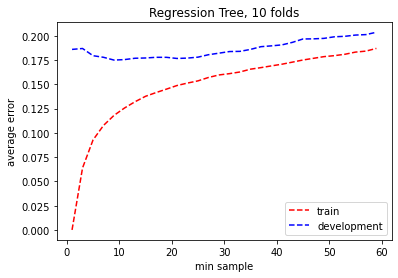

In [ ]:
n_folds = 10
min_samples = list(range(1,61,2))
clf_reg_tree_min = GridSearchCV(estimator=tree.DecisionTreeRegressor(random_state=0), param_grid={'min_samples_leaf':min_samples}, scoring = 'neg_root_mean_squared_error', return_train_score=True, cv=n_folds)
clf_reg_tree_min.fit(X_whole_no_outliers, y_whole_no_outliers)

plt.xlabel('min sample')
plt.ylabel('average error')
plt.title("Regression Tree, " + str(n_folds) + " folds")
plt.plot(clf_reg_tree_min.cv_results_["param_min_samples_leaf"], -clf_reg_tree_min.cv_results_["mean_train_score"], 'r--', label="train")
plt.plot(clf_reg_tree_min.cv_results_["param_min_samples_leaf"], -clf_reg_tree_min.cv_results_["mean_test_score"], 'b--', label="development")
plt.legend()
plt.show()



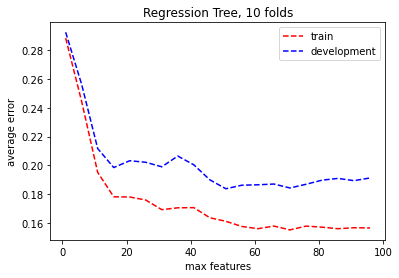

In [ ]:
min_samples_leaf = 20 # Tuned parameter from previous cell
max_features = list(range(1,101,5))
n_folds = 10
clf_reg_tree_maxfeat = GridSearchCV(estimator=tree.DecisionTreeRegressor(random_state=0,min_samples_leaf=min_samples_leaf), param_grid={'max_features':max_features}, scoring = 'neg_root_mean_squared_error', return_train_score=True, cv=n_folds)
clf_reg_tree_maxfeat.fit(X_whole_no_outliers, y_whole_no_outliers)
plt.xlabel('max features')
plt.ylabel('average error')
plt.title("Regression Tree, " + str(n_folds) + " folds")
plt.plot(clf_reg_tree_maxfeat.cv_results_["param_max_features"], -clf_reg_tree_maxfeat.cv_results_["mean_train_score"], 'r--', label="train")
plt.plot(clf_reg_tree_maxfeat.cv_results_["param_max_features"], -clf_reg_tree_maxfeat.cv_results_["mean_test_score"], 'b--', label="development")
plt.legend()
plt.show()

We choose the hyperparameters at the "elbow" of each graph. That is, we choose the hyperparameter values such that increasing the hyperparameter's value further will not change the error much.

In [ ]:
# Train and Predict

# Tuned Hyperparamters:
tuned_min_samples_leaf = 20
tuned_max_features = 60

tree_regressor = tree.DecisionTreeRegressor(random_state=0, min_samples_leaf=tuned_min_samples_leaf, max_features=tuned_max_features)
tree_regressor = tree_regressor.fit(X_whole_no_outliers, y_whole_no_outliers)

y_predict_tree = tree_regressor.predict(X_test_df)
y_predict_tree = np.exp(y_predict_tree)


save_predictions(y_predict_tree, 'predict_test_tree', path_pref, X_test.index)

Within our Kaggle submissions, Regression Trees heavily underperformed, with the score of 0.19098. This poor performance was somewhat expected, as the cross validation results showed poor performance on the development set regardless of the hyperparameters chosen. Thus, we decided to abondon this approach in favor of other approaches.

## SVM regression


SVR [(Drucker et. al., 1997)](https://proceedings.neurips.cc/paper/1996/file/d38901788c533e8286cb6400b40b386d-Paper.pdf) is the extension of SVM to regression proposed by Harris Drucker et al. in 1997. It maintains all the features in SVM like maximal margin. The concept is pretty similar to SVM: to learn the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated. SVR has three main hyperparameters. The epsilon is the tolerance for error, C is the regularization parameter and kernel is the type of kernel. Depending on the kernel, it may have parameters as well, like gamma for rbf kernel and degree for polynomial kernel.
Let's start with optmizing hyperparameters with GridSearchCV for the case of rbf and linear and different values of C and epsilon.

In [ ]:
 # # Due to long runtime (50 minutes), the output graph is shown in the next cell.
# # Uncomment the following line to run the code.

# eps_list = [0.01, 0.1, 0.15 ,0.25, 0.5, 0.75, 1, 1.5]
# clf_SVR = GridSearchCV(SVR(gamma='auto'),{
#     'C':[1,5,10],
#     'kernel': ['rbf', 'linear'],
#     'epsilon': eps_list
# }, cv=5, scoring='neg_mean_squared_error', return_train_score=True, refit=True)

# clf_SVR.fit(X_whole_no_outliers, y_whole_no_outliers)
# svr_cv_results = pd.DataFrame(clf_SVR.cv_results_)





# plt.figure(figsize=(20,10))


# plt.subplot(321)

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='rbf')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='rbf')]["mean_train_score"], 'r--', label="train- C=1, kernel=RBF")

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='rbf')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='rbf')]["mean_test_score"], 'b--', label="test- C=1, kernel=RBF")

# plt.xlabel('epsilon')
# plt.ylabel('average error')
# plt.legend()


# plt.subplot(322)

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='linear')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='linear')]["mean_train_score"], 'r--', label="train- C=1, kernel=linear")

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='linear')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==1) & (svr_cv_results["param_kernel"]=='linear')]["mean_test_score"], 'b--', label="test- C=1, kernel=linear")

# plt.xlabel('epsilon')
# plt.ylabel('average error')
# plt.legend()

# plt.subplot(323)

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='rbf')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='rbf')]["mean_train_score"], 'r--', label="train- C=5, kernel=RBF")

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='rbf')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='rbf')]["mean_test_score"], 'b--', label="test- C=5, kernel=RBF")

# plt.xlabel('epsilon')
# plt.ylabel('average error')
# plt.legend()

# plt.subplot(324)
# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='linear')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='linear')]["mean_train_score"], 'r--', label="train- C=5, kernel=linear")

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='linear')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='linear')]["mean_test_score"], 'b--', label="test- C=5, kernel=linear")

# plt.xlabel('epsilon')
# plt.ylabel('average error')
# plt.legend()

# plt.subplot(325)

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==10) & (svr_cv_results["param_kernel"]=='rbf')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='rbf')]["mean_train_score"], 'r--', label="train- C=10, kernel=RBF")

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==10) & (svr_cv_results["param_kernel"]=='rbf')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==5) & (svr_cv_results["param_kernel"]=='rbf')]["mean_test_score"], 'b--', label="test- C=10, kernel=RBF")

# plt.xlabel('epsilon')
# plt.ylabel('average error')
# plt.legend()

# plt.subplot(326)
# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==10) & (svr_cv_results["param_kernel"]=='linear')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==10) & (svr_cv_results["param_kernel"]=='linear')]["mean_train_score"], 'r--', label="train- C=10, kernel=linear")

# plt.plot(svr_cv_results[(svr_cv_results["param_C"]==10) & (svr_cv_results["param_kernel"]=='linear')]["param_epsilon"]
# , -svr_cv_results[(svr_cv_results["param_C"]==10) & (svr_cv_results["param_kernel"]=='linear')]["mean_test_score"], 'b--', label="test- C=10, kernel=linear")

# plt.xlabel('epsilon')
# plt.ylabel('average error')
# plt.legend()

# plt.show()
# y_predict_svr = clf_SVR.predict(X_test_df)
# save_predictions(np.exp(y_predict_svr), 'predict_test_svr', path_pref, X_test.index)

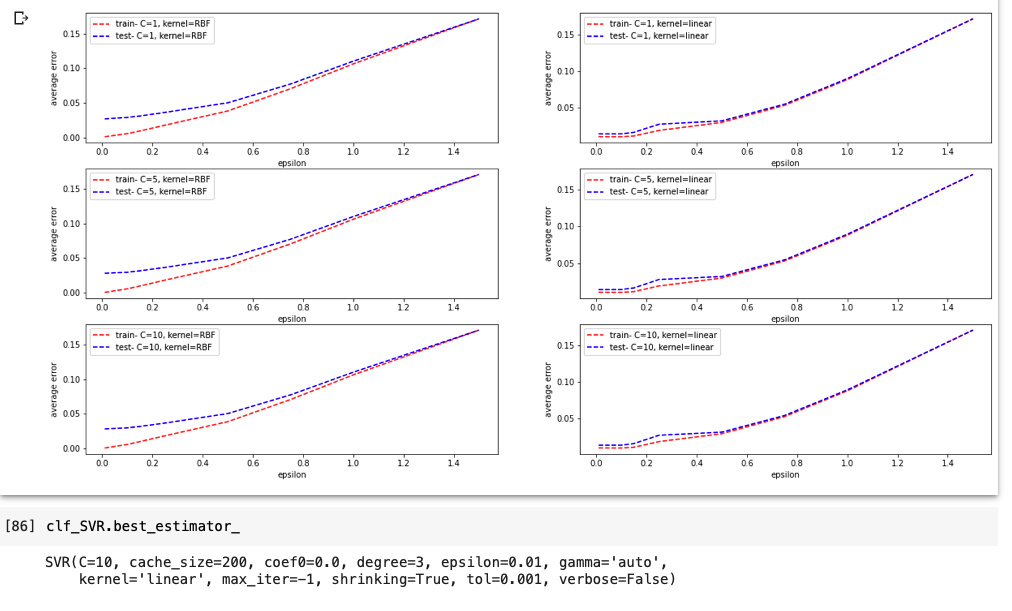

In [ ]:
svr_best = SVR(C=10, degree=3, epsilon=0.01, gamma='auto', kernel='linear')
svr_best.fit(X_whole_no_outliers, y_whole_no_outliers)
y_test_predict_svr = svr_best.predict(X_test_df)

The gridsearch on SVR takes a lot of time to run. Therefore, the screenshot of the results of this cell is presented here.
From the figures above, there isn't significant difference between C=1 and C=5 and both represent good regularization as the training error and the dev error are similar (we added C=10 after this observation to see the effect of more regularization). The range of the values for error tolerance term epsilon shows the behavior change properly. The lower the epsilon, the pickier the model. Therefore the possibility of overfitting is higher in lower values of epsilon.
The best estimator of SVR is with linear kernel. Using nonlinear kernels, the model tends to overfit to the training data as there is a difference between the error of training set and the dev set. We tried this model on the test set on Kaggle and got a score of 0.13487.

## XGBoost

XGBoost(eXtreme Gradient Boosting) [(XGboost documentation, 2020)](https://xgboost.readthedocs.io/en/latest/) is an open-source software library which provides a gradient boosting framework and provide a "Scalable, Portable and Distributed Gradient Boosting Library".

Basically, XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. 


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/700/1*FLshv-wVDfu-i54OqvZdHg.png")

In [ ]:
Image(url= "https://miro.medium.com/max/700/1*U72CpSTnJ-XTjCisJqCqLg.jpeg")

The "XGBoost" tool in python gives us a wide variety of internal tuning parameters. It is based on tree ensembles (forest) which are sets of Classification and Regression Trees ([CART](https://www.datacamp.com/community/tutorials/xgboost-in-python)) (Pathak, 2019). Trees are grown in a steady progression ,and attemps to diminish the misclassification rate are made in subsequent iterations. A comprehensive exploration of "XGBoost" can be found in this [link](https://www.youtube.com/watch?v=Vly8xGnNiWs) that demonstrates each tree gives a different prediction score depending on the data it sees and the scores of each individual tree are summed up to get the final score. The following figures show the capabilities of XGBoost and how it outperfomrs its alternatives.

The model has a bunch of tuning parameters for tree-based learners in XGBoost the most important ones are (Pathak, 2019):


* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]

* max_depth: determines how deeply each tree is allowed to grow during any boosting round.

* subsample: percentage of samples used per tree. Low value can lead to underfitting.

* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.

* n_estimators: number of trees you want to build.

* gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.

* reg_alpha: L1 regularization on leaf weights. A large value leads to more regularization.

* reg_lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

* min_child_weight: The larger min_child_weight is, the more conservative the algorithm will be.

* seed: for reproducibility of results.

* silent: Whether print messages during construction



The implementation of the model would be as the following:





### Grid Search for XGBoost

We use GridSearchCV function benefitting from the cross validation technique to tune hyper parameters of XGBoost. We later apply the same technique to the LGBM models. We determine 5 folds to go over the data through random train-development sections. The mean and variance of the error for the five fold is important to be optimized.

Our evaluation function for the root mean square error is the negative mean squared function on the logarithm of estimated sales prices. This is matched to Kaggle's method of evaluation.

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_whole_no_outliers.values)
    rmse= np.sqrt(-cross_val_score(model, X_whole_no_outliers.values, y_whole_no_outliers, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Due to processor's limitations, we cannot tune all hyperparameters simultaneously. After many estimations, evaluations, and trial and error, we ended up with the parameters shown below. To check how the grid search function work, the reader can uncomment any of the parameters in the "param_grid" and comment the same parameter in the "params".

In [ ]:
params = {
    'task' : 'train',
    'objective' : 'reg:linear',
    'colsample_bytree':0.2,
    'gamma':0,
    'learning_rate':0.05,
    # 'max_depth':6,
    'min_child_weight':1.5,
    'n_estimators':7200,                                                                  
    'reg_alpha':0.9,
    'reg_lambda':0.6,
    'subsample':0.2,
    'seed':42,
    'silent':1
}

param_grid = {
    # 'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
    # 'gamma' : [0,0.05,0.1,0.15,0.2],
    # 'max_depth':[5, 6, 7, 8, 9, 10],
    # 'reg_alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    # 'reg_lambda' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    # 'sub_sample' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    # 'colsample_bytree' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    # 'n_estimators': [7200, 3600, 1200, 2400]
}

## remove each parameter form "params" and uncomment the same one in the "param_grid" for trial and error.

reg_xgb = xgb.XGBRegressor(**params, verbose=-1)

xgb_grid  = GridSearchCV(reg_xgb, 
                          param_grid, 
                          cv=n_folds, 
                          scoring='neg_mean_squared_error', 
                          return_train_score=True)

xgb_grid.fit(X_whole_no_outliers, y_whole_no_outliers)

r2_score(xgb_grid.predict(X_whole_no_outliers), y_whole_no_outliers)

reg_xgb.fit(X_whole_no_outliers,y_whole_no_outliers)

score = rmsle_cv(reg_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
print(xgb_grid.best_estimator_)

XGBoost score: 0.1167 (0.0059)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None, n_estimators=7200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1, seed=42,
             silent=1, subsample=0.2, task='train', verbose=-1, verbosity=1)


In [ ]:
y_test_predict_xgb = reg_xgb.predict(X_test)

save_predictions(np.exp(y_test_predict_xgb), 'predict_test_xgb', path_pref, X_test.index)

We also visualize individual trees from the XGBoost model. Below we only show 10 sample trees in the following:

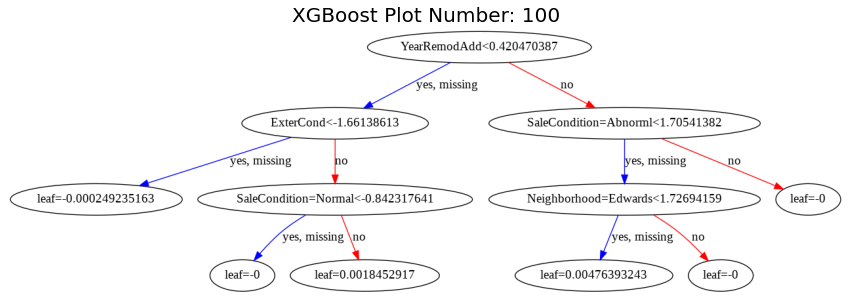

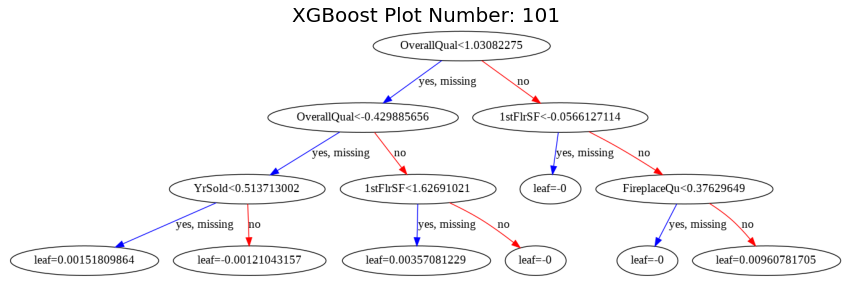

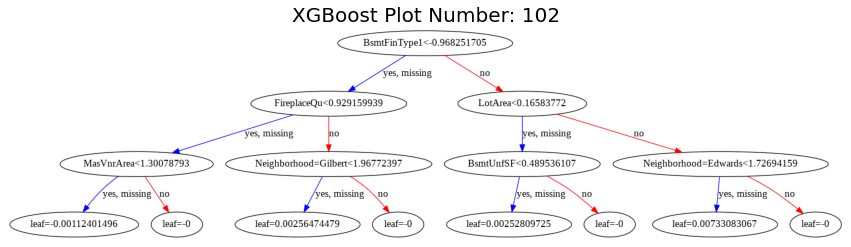

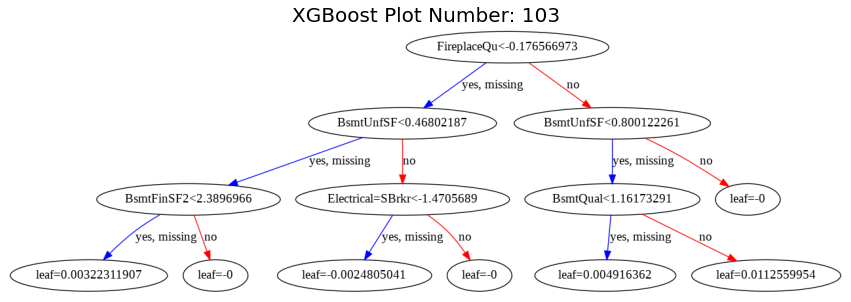

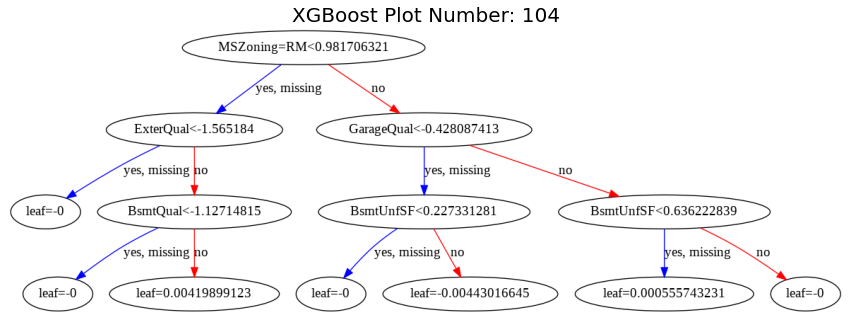

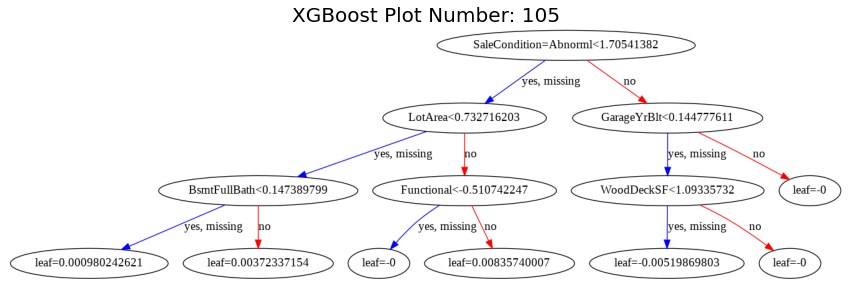

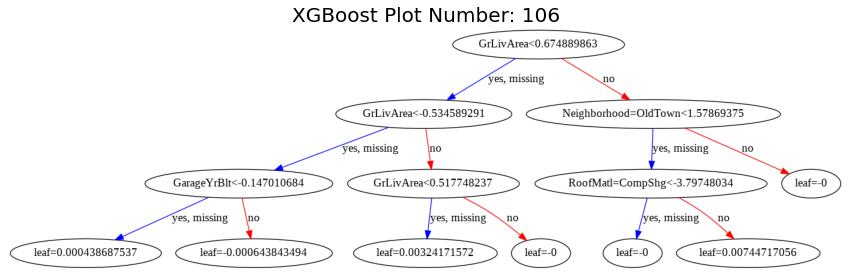

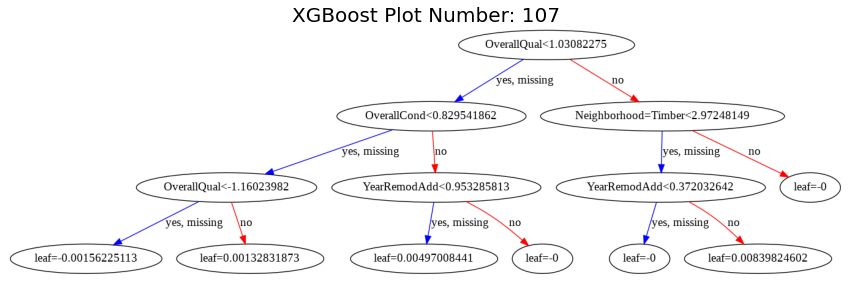

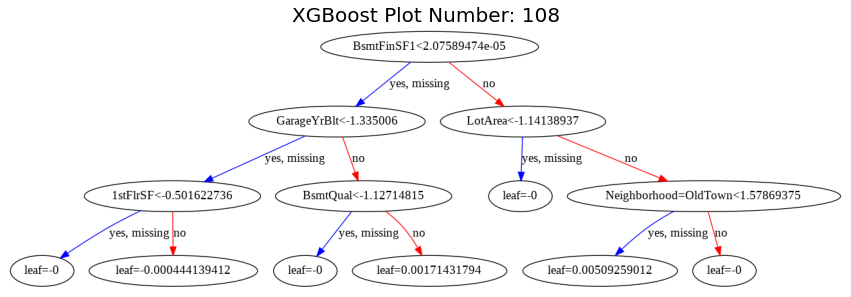

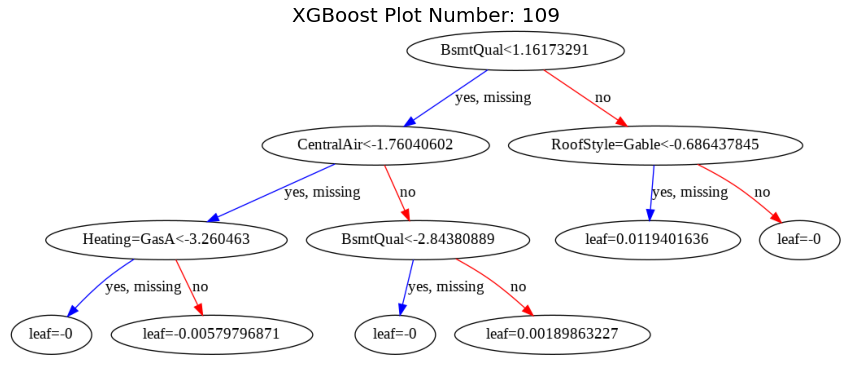

In [ ]:
for plot_num in range (100,110):
   fig, ax = plt.subplots(figsize=(15, 15))
   ax = xgb.plot_tree(reg_xgb,ax=ax, num_trees=plot_num)
   ax.set_title("XGBoost Plot Number: "+str(plot_num), fontsize=20)

   plt.show()

### XGBoost with PCA
We reduce the dimension of our data before we run XGBoost. We will refer to the "Dimensionality Reduction" section of the notebook for a discussion of the effectiveness of PCA on XGBoost.

In [ ]:

# Tuned number of principal components
num_components = 130

# Dimensionality Reduction
pca = PCA(n_components = num_components)
pca.fit(X_whole_no_outliers)
X_whole_pca = pca.transform(X_whole_no_outliers)

# Training
reg_xgb_pca = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
reg_xgb_pca.fit(X_whole_pca, y_whole_no_outliers)

# Prediction
X_test_pca = pca.transform(X_test_df)
y_test_predict_xgb_pca = np.exp(reg_xgb_pca.predict(X_test_pca))

# Export results to csv
save_predictions(y_test_predict_xgb_pca, 'predict_test_xgb_pca', path_pref, X_test.index)

## LGBM

Light Gradient Boosting Machine ([LGBM](https://github.com/microsoft/LightGBM)) (LGBM's documentation, 2020) is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks. The development focus is on performance and scalability.

We use this toolkit's regressor to estimate the housing prices.

In [ ]:
Image(url="https://lightgbm.readthedocs.io/en/latest/_static/LightGBM_logo_grey_text.svg", width=500)

The list of [parameters](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) we are tuning are as follows:


* learning_rate: step size shrinkage used to prevent overfitting.  
* num_leaves: To control the complexity of the tree and its convergance.
* min_data_in_leaf: To control overfitting. Higher values lead to less over-fitting but oversizing it would result in underfitting. It mostlydepends to the size and type of data.
* max_depth: To limit the depth of the tree for faster processing.
* min_sum_hessian_in_leaf: for minimal sum hessian in one leaf that can be used to deal with over-fitting.
* feature_fraction: LGBM will randomly select a subset of features on each iteration (tree). This reduces the training time and overfitting.
* bagging_fraction: similar to feature_fraction, and this can be used to reduce training steps.
* baging_freq: Frequency for bagging.
* n_estimators: number of trees you want to build.


We apply the cross-validation method using 5 folds to find the optimal values for some hyperparameters.



### Grid Search for LGBM

We use the same gridsearch function we got benefit from, while training the XGBoost model, to train the LGBM model: 

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_whole_no_outliers.values)
    rmse= np.sqrt(-cross_val_score(model, X_whole_no_outliers.values, y_whole_no_outliers, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
params = {
    'task' : 'train',
    'objective' : 'regression',
    'num_leaves':5,
    'learning_rate':0.05, 
    'n_estimators':720,
    'max_bin':55,
    'bagging_fraction': 0.8,
    'bagging_freq':5, 
    'feature_fraction': 0.2319,
    'feature_fraction_seed':9, 
    'bagging_seed':9,
    'min_data_in_leaf':6, 
    'min_sum_hessian_in_leaf': 11
}

param_grid = {
    # 'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
    # 'feature_fraction' : [0.2,0.21,0.22,0.23,0.24,0.25],
    # 'num_leaves':[5, 10, 30, 60, 120],
    # 'bagging_fraction' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    # 'n_estimators': [720, 360, 120, 1200]
    # 'min_data_in_leaf':[1,2,3,4,5,6,7,8,9,10],
    # 'bagging_freq':[1,2,3,4,5,6,7,8,9,10]
}

## remove each parameter form "params" and uncomment the same one in the "param_grid" for trial and error.

reg_lgb = lgbm.LGBMRegressor(**params, verbose=-1)

lgbm_grid  = GridSearchCV(reg_lgb, 
                          param_grid, 
                          cv=n_folds, 
                          scoring='neg_mean_squared_error', 
                          return_train_score=True)

lgbm_grid.fit(X_whole_no_outliers, y_whole_no_outliers)

r2_score(lgbm_grid.predict(X_whole_no_outliers), y_whole_no_outliers)

reg_lgb.fit(X_whole_no_outliers,y_whole_no_outliers)

score = rmsle_cv(reg_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
print(lgbm_grid.best_estimator_)

LGBM score: 0.1158 (0.0049)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=-1)


In [ ]:
y_test_predict_lgb= reg_lgb.predict(X_test)

In [ ]:
predict_test_lgb_df = pd.DataFrame(np.exp(y_test_predict_lgb))


predict_test_lgb_df.rename(columns={0:'SalePrice',}, 
                 inplace=True)

predict_test_lgb_df['Id']=X_test.index
predict_test_lgb_df=predict_test_lgb_df.set_index('Id')

predict_test_lgb_df.to_csv(path_pref+'predict_test_lgb.csv')

In the same way as XGBoost, we show some sample trees created by our LGBM model in the following:

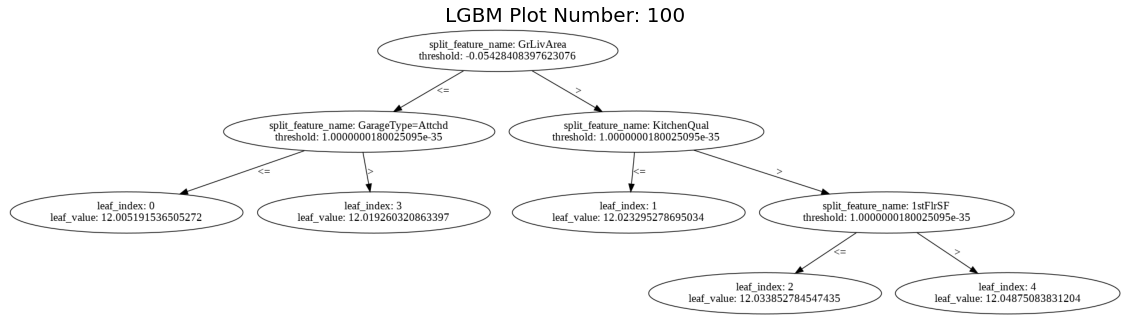

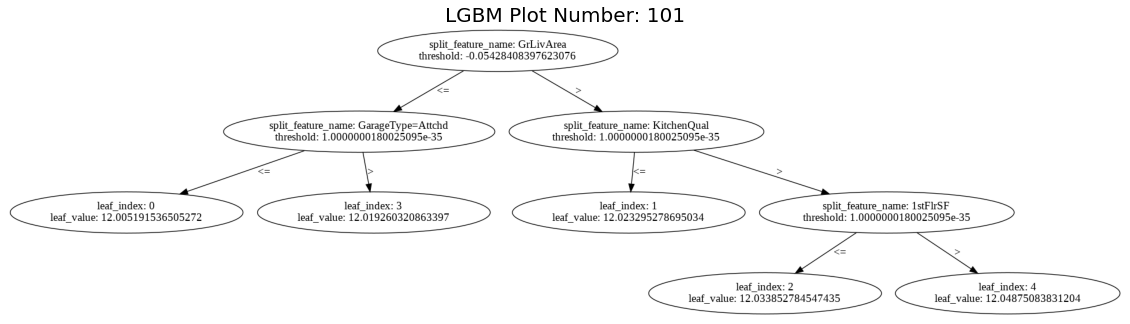

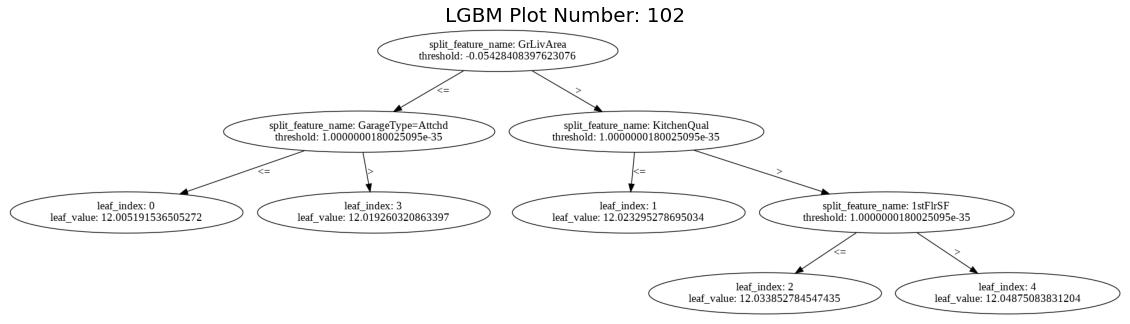

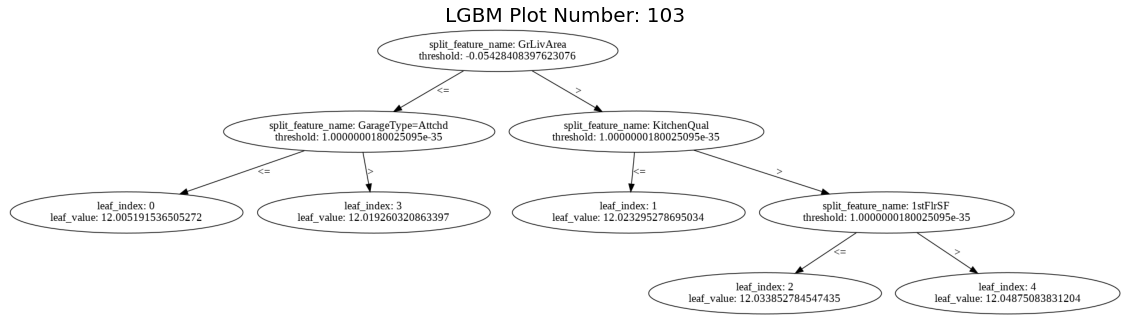

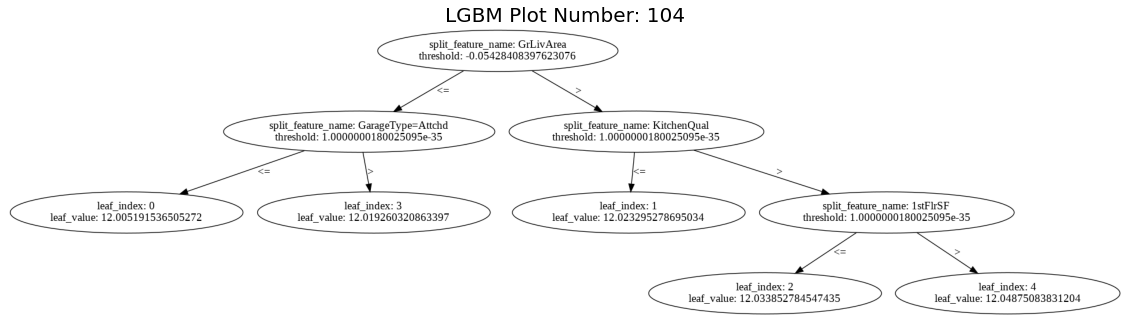

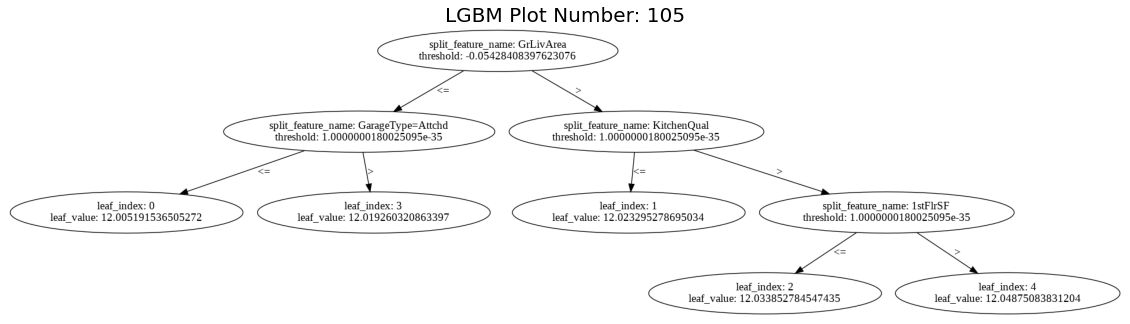

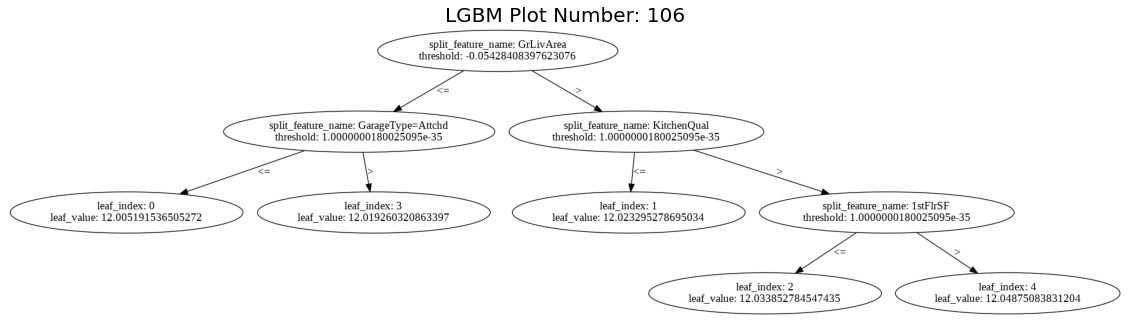

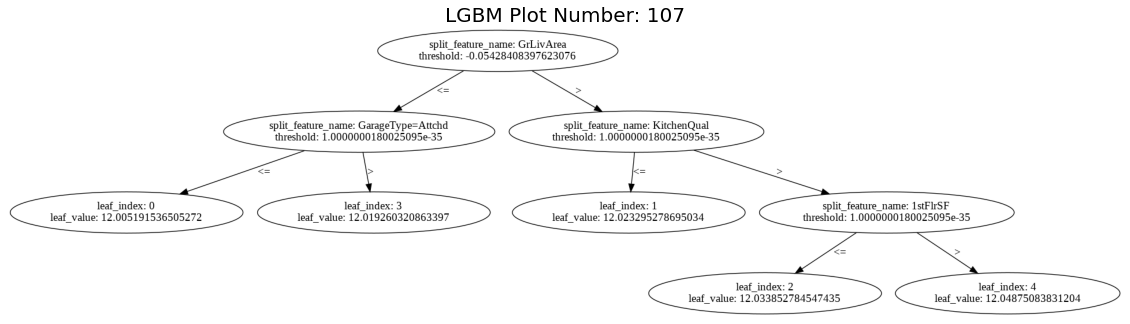

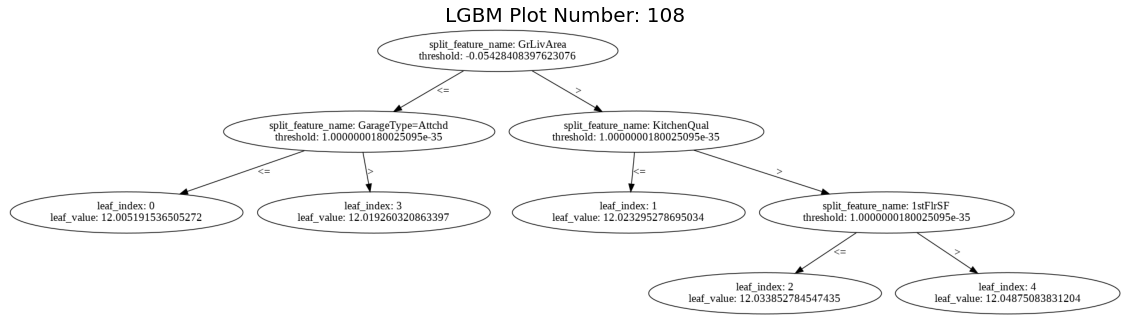

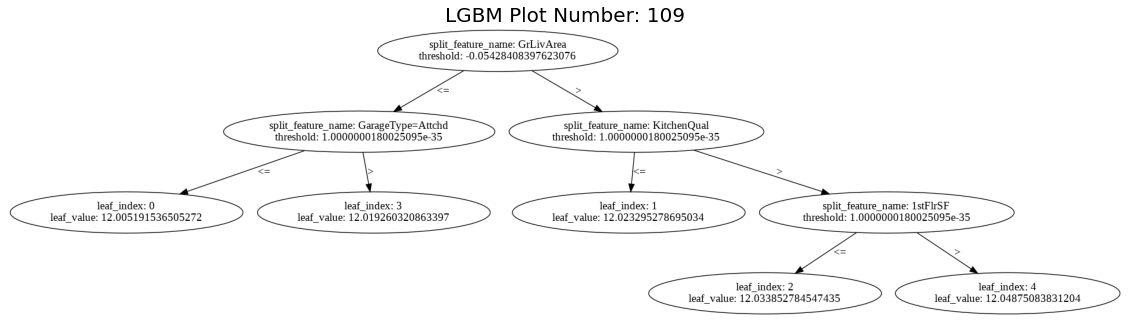

In [ ]:
for plot_num in range (100,110):
   ax = lgbm.plot_tree(reg_lgb, figsize=(20,20))
   ax.set_title("LGBM Plot Number: "+str(plot_num), fontsize=20)
   plt.show()

### LGBM + PCA
We perform the same PCA techniques on LGBM as well.

In [ ]:

# Tuned number of principal components
num_components = 130

# Dimensionality Reduction
pca = PCA(n_components = num_components)
pca.fit(X_whole_no_outliers)
X_whole_pca = pca.transform(X_whole_no_outliers)

# Training
reg_lgb_pca = lgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

reg_lgb_pca.fit(X_whole_pca, y_whole_no_outliers)

# Prediction
X_test_pca = pca.transform(X_test_df)
y_test_predict_lgb_pca = np.exp(reg_lgb_pca.predict(X_test_pca))

# Export results to csv
save_predictions(y_test_predict_lgb_pca, 'predict_test_lgb_pca', path_pref, X_test.index)

## **Key Technique: Log Averaging**

We were never be able to beat the score 0.121 without using Log averaging technique. Initially we wanted to combine the predictions from different models to get a lower error rate, but averaging the actual estimated prices of the test data was never helpful. Later we figured out that since the data is severely skewed, we should try averaging over the **Logarithm of predictions** and apply the exponential term after the averaging technique.

$$Predict_{avg}= exp\left(\frac{1}{N} \sum_i^N Log(Predict_{method_i})\right)$$

After some experiments, we observed that the best accuracy is achieved by combining the results obtained by Ridge, Lasso, XGBoost, and LGBM methods and calculating their unweighted Log average. We also tried including the predictions from the SVR method in the average, but we obtained a lower score. This might be due to potential larger overfitting of the SVR model.

The following code shows how we apply the unweighted averaging technique:

In [ ]:

y_test_predict_avg_5= 0.2*y_test_predict_xgb+ 0.2*y_test_predict_lgb + 0.2*y_test_predict_svr + 0.2*y_test_predict_ridge+0.2*y_test_predict_lasso
y_test_predict_avg_5= test_outlier_replace(y_test_predict_avg_5, y_whole_no_outliers.min(), y_whole_no_outliers.max(),  y_whole_no_outliers.mean())
save_predictions(np.exp(y_test_predict_avg_5), 'predict_test_avg_5', path_pref, X_test.index)

y_test_predict_avg_4= 0.25*y_test_predict_xgb+ 0.25*y_test_predict_lgb +  0.25*y_test_predict_ridge+0.25*y_test_predict_lasso
y_test_predict_avg_4= test_outlier_replace(y_test_predict_avg_4, y_whole_no_outliers.min(), y_whole_no_outliers.max(),  y_whole_no_outliers.mean())
save_predictions(np.exp(y_test_predict_avg_4), 'predict_test_avg_4', path_pref, X_test.index)



# Discussion & Conclusion




## Comparing candidate models:


In this section, we wrap up all our results and observations based on various models we introduces. The following code will perform cross validation on our top 4 models including Ridge, Lasso, XGBoost, and LGBM, and we compare their performance with the averaged model. The average model has the best performance on Kaggle 0.11643. 

In [ ]:
kf = KFold(n_splits = n_folds, random_state=0, shuffle=True)
kf.get_n_splits(X_whole_no_outliers)

train_error = []
test_error = []
xgb_best_params = {
    'task' : 'train',
    'objective' : 'reg:linear',
    'colsample_bytree':0.2,
    'gamma':0,
    'learning_rate':0.05,
    # 'max_depth':6,
    'min_child_weight':1.5,
    'n_estimators':7200,                                                                  
    'reg_alpha':0.9,
    'reg_lambda':0.6,
    'subsample':0.2,
    'seed':42,
    'silent':1
}

lgb_best_params = {
    'task' : 'train',
    'objective' : 'regression',
    'num_leaves':5,
    'learning_rate':0.05, 
    'n_estimators':720,
    'max_bin':55,
    'bagging_fraction': 0.8,
    'bagging_freq':5, 
    'feature_fraction': 0.2319,
    'feature_fraction_seed':9, 
    'bagging_seed':9,
    'min_data_in_leaf':6, 
    'min_sum_hessian_in_leaf': 11
}


train_error_ridge = []    
train_error_lasso = []
train_error_xgb = []
train_error_lgb = []
train_error_avg = [] 

test_error_ridge = [] 
test_error_lasso = []
test_error_xgb = []
test_error_lgb = []
test_error_avg = []




for train_index, test_index in kf.split(X_whole_no_outliers):
    model_ridge = Ridge(max_iter=100000, alpha=0.000003)
    model_lasso = Lasso(max_iter=100000, alpha=2e-5)
    model_xgb = xgb.XGBRegressor(**xgb_best_params, verbose=-1)
    model_lgb = lgbm.LGBMRegressor(**lgb_best_params, verbose=-1)

    X_train, X_dev = X_whole_no_outliers.iloc[train_index], X_whole_no_outliers.iloc[test_index]
    y_train, y_dev = y_whole_no_outliers.iloc[train_index], y_whole_no_outliers.iloc[test_index]

    model_ridge.fit(X_train, y_train)
    model_lasso.fit(X_train, y_train)
    model_xgb.fit(X_train, y_train)
    model_lgb.fit(X_train, y_train)

    y_train_pred_ridge = model_ridge.predict(X_train)
    y_train_pred_lasso = model_lasso.predict(X_train)
    y_train_pred_xgb = model_xgb.predict(X_train)
    y_train_pred_lgb = model_lgb.predict(X_train)
    y_train_pred_avg = 0.25*(y_train_pred_ridge+y_train_pred_lasso+y_train_pred_xgb+y_train_pred_lgb)
  

    y_dev_pred_ridge = model_ridge.predict(X_dev)
    y_dev_pred_lasso = model_lasso.predict(X_dev)
    y_dev_pred_xgb = model_xgb.predict(X_dev)
    y_dev_pred_lgb = model_lgb.predict(X_dev)
    y_dev_pred_avg = 0.25*(y_dev_pred_ridge+y_dev_pred_lasso+y_dev_pred_xgb+y_dev_pred_lgb)


    train_error_ridge += [mean_squared_error(y_train, y_train_pred_ridge, squared=False)]
    train_error_lasso += [mean_squared_error(y_train, y_train_pred_lasso, squared=False)]
    train_error_xgb += [mean_squared_error(y_train, y_train_pred_xgb, squared=False)]
    train_error_lgb += [mean_squared_error(y_train, y_train_pred_lgb, squared=False)]
    train_error_avg += [mean_squared_error(y_train, y_train_pred_avg, squared=False)]

    test_error_ridge += [mean_squared_error(y_dev, y_dev_pred_ridge, squared=False)]
    test_error_lasso += [mean_squared_error(y_dev, y_dev_pred_lasso, squared=False)]
    test_error_xgb += [mean_squared_error(y_dev, y_dev_pred_xgb, squared=False)]
    test_error_lgb += [mean_squared_error(y_dev, y_dev_pred_lgb, squared=False)]
    test_error_avg += [mean_squared_error(y_dev, y_dev_pred_avg, squared=False)]

avg_train_error_ridge = sum(train_error_ridge) / n_folds
avg_train_error_lasso = sum(train_error_lasso) / n_folds
avg_train_error_xgb = sum(train_error_xgb) / n_folds
avg_train_error_lgb = sum(train_error_lgb) / n_folds
avg_train_error_avg = sum(train_error_avg) / n_folds

avg_test_error_ridge = sum(test_error_ridge) / n_folds
avg_test_error_lasso = sum(test_error_lasso) / n_folds
avg_test_error_xgb = sum(test_error_xgb) / n_folds
avg_test_error_lgb = sum(test_error_lgb) / n_folds
avg_test_error_avg = sum(test_error_avg) / n_folds

print("avg_train_error_ridge: "+ str(avg_train_error_ridge))
print("avg_train_error_lasso: "+ str(avg_train_error_lasso))
print("avg_train_error_xgb: "  + str(avg_train_error_xgb))
print("avg_train_error_lgb: "   + str(avg_train_error_lgb))
print("avg_train_error_avg: "   + str(avg_train_error_avg))


print("avg_test_error_ridge: " + str(avg_test_error_ridge))
print("avg_test_error_lasso: " + str(avg_test_error_lasso))
print("avg_test_error_xgb: "   + str(avg_test_error_xgb))
print("avg_test_error_lgb: " + str(avg_test_error_lgb))
print("avg_test_error_lgb: " + str(avg_test_error_avg))






avg_train_error_ridge: 0.09399726809991739
avg_train_error_lasso: 0.09400107042159497
avg_train_error_xgb: 0.05571060766121183
avg_train_error_lgb: 0.06831572393348011
avg_train_error_avg: 0.07350616699266559
avg_test_error_ridge: 0.1155007145509773
avg_test_error_lasso: 0.1153312767188563
avg_test_error_xgb: 0.11788821981594624
avg_test_error_lgb: 0.11605785507373723
avg_test_error_lgb: 0.10959499993764757


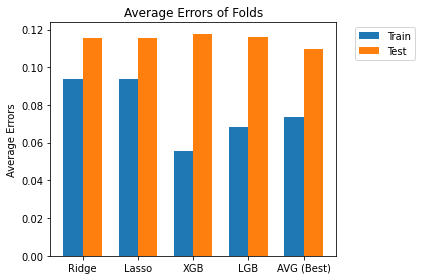

In [ ]:
labels = ['Ridge','Lasso', 'XGB', 'LGB', 'AVG (Best)']
train_labels = [avg_train_error_ridge, avg_train_error_lasso, avg_train_error_xgb, avg_train_error_lgb, avg_train_error_avg]
test_labels = [avg_test_error_lasso, avg_test_error_lasso, avg_test_error_xgb, avg_test_error_lgb, avg_test_error_avg]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_labels, width, label='Train')
rects2 = ax.bar(x + width/2, test_labels, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Errors')
ax.set_title('Average Errors of Folds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()

plt.show()


## Conclusions on Models

Based on all the models we tested in this phase, XGBoost (0.12295) and LGBM (0.1236) provide the best results compared to Lasso (0.13409), Ridge (0.13259), Regression Tree (0.19098), and SVR (0.13487) (The numbers in the parantheses are the scores we obtained on Kaggle). XGBoost and LGBM have test errors of 0.12295 and 0.1236 separately on the kaggle test dataset. 
By combining Lasso, Ridge, XGBoost, and LGBM methods using the unweighted average technique on the logarithm of the estimated prices, we could boost the Kaggle score to **0.12067**. Although the average technique does not affect the mean of errors severly, it decreases the standard deviation of the error amongst different folds. Having a low standard deviation error is a MUST to get a good score on the test set.

We also detected a single outlier in the test data (number #2550). To prevent huge errors caused by this single data point, for estimated prices larger than the maximum price in the training set with no outliers (i.e., $>$ ~\\$625,000), we replace the predicted value by the average of training set prices ( ~ \\$180,921). This is what we applied only on the data number# 2550. The original estimated price was first $>$ ~\\$800,000 which is much higher than the maximum price in the training data so we decrease it to \\$180,921. This single change, decreased the error from **0.12067** to **0.11643**.  

## Future Work

So far we have tested unweighted averaging on 4 of our best models. However, there are still room for boosting the predictions by combining more and better models in an ensemble. A great progress one can make on this research is to add a hyperparameter vector that makes a weighted average of several good models and estimates the best prediction based on the ensemble. Next improvement is to add a bias term and tune it to minimize the error. 
Another avenue for exploring is using the kernelized version of models. There are different kernels that are worth trying: 1) the Radial Basis Function (RBF) and the polynomial kernel. The feature space for RBF kernel has infinite dimensions. This helps the model to be more expressive, however our initial experience showed that increases the tendency to overfit the training data. This requires larger grids for hyperparameter tunning to come up with a model with a better performance in generalization. 

# References

* Choudhary, Amit. “script_v6.” Kaggle, Kaggle, 8 Dec. 2016, www.kaggle.com/amitchoudhary/script-v6. 

* Drucker, Harris, et al. “Support Vector Regression Machines.” Advances in Neural Information Processing Systems 9, 1997, pp. 155–161. 

* Dutta, Kartike. “House Prices: Advanced Regression Techniques.” Kaggle, Kaggle, 9 July 2018, www.kaggle.com/kartikdutt28/house-prices-advanced-regression-techniques. 

* Guthrie, WIlliam F. NIST/SEMATECH e-Handbook of Statistical Methods, National Institute of Standards and Technology, 2020, www.itl.nist.gov/div898/handbook/. 

* Harless, Andy. “Amit Choudhary's Kernel Notebook-Ified.” Kaggle, Kaggle, 30 Apr. 2017, www.kaggle.com/aharless/amit-choudhary-s-kernel-notebook-ified. 

* “House Prices - Advanced Regression Techniques.” Kaggle, Kaggle, www.kaggle.com/c/house-prices-advanced-regression-techniques/overview. 

* Krishnan, Adithya. “Anomaly Detection with Isolation Forest &amp; Visualization.” Medium, Towards Data Science, 4 Mar. 2019, towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2. 

* Kim, Seung-Jean, et al. “An Interior-Point Method for Large-Scale -Regularized Least Squares.” IEEE Journal of Selected Topics in Signal Processing, vol. 1, no. 4, 2007, pp. 606–617., doi:10.1109/jstsp.2007.910971. 

* “Kurtosis.” Wikipedia, Wikimedia Foundation, 20 Apr. 2021, en.wikipedia.org/wiki/Kurtosis. 

* “LightGBM's Documentation.” Welcome to LightGBM's Documentation! - LightGBM 3.2.1.99 Documentation, Microsoft Corporation, 2021, lightgbm.readthedocs.io/en/latest/. 

* Liu, Fei Tony, et al. “Isolation Forest.” 2008 Eighth Ieee International Conference on Data Mining, 2008, doi:https://doi.org/10.1109/ICDM.2008.17. 

* Pathak, Manish. “(Tutorial) Learn to Use XGBoost in Python.” DataCamp Community, 8 Nov. 2019, www.datacamp.com/community/tutorials/xgboost-in-python. 

* Rifkin, Ryan M, and Ross A Lippert. “Notes on Regularized Least Squares.” 2007. 

* “Scipy.stats.skew.” Scipy.stats.skew - SciPy v1.6.3 Reference Guide, docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html. 

* Shahules. “An Overview of Encoding Techniques.” Kaggle, Kaggle, 23 Oct. 2019, www.kaggle.com/shahules/an-overview-of-encoding-techniques. 

* “Skewness.” Wikipedia, Wikimedia Foundation, 14 Apr. 2021, en.wikipedia.org/wiki/Skewness. 

* Weng, Jiahao. “Exploratory Data Analysis (EDA): A Practical Guide and Template for Structured Data.” Medium, Towards Data Science, 24 Sept. 2019, towardsdatascience.com/exploratory-data-analysis-eda-a-practical-guide-and-template-for-structured-data-abfbf3ee3bd9. 

* “XGBoost Documentation.” XGBoost Documentation - Xgboost 1.5.0-SNAPSHOT Documentation, Xgboost Developers, 2020, xgboost.readthedocs.io/en/latest/. 

